In [1]:
# Test migration history reconstruction on simulated data

import sys
import os

repo_dir = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/"
os.chdir(repo_dir)
from src.lib import vertex_labeling

from src.util import data_extraction_util as data_util
from src.util import vertex_labeling_util as vert_util
import matplotlib
import torch

MACHINA_DATA_DIR = os.path.join(repo_dir, 'src/data/machina_sims')


20:39:19 INFO
NumExpr defaulting to 8 threads.


CUDA GPU: False
CUDA GPU: False
CUDA GPU: False


In [11]:
#custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'cornflowerblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]
custom_colors = ["#6aa84fff","#c27ba0ff", "#be5742e1", "#6fa8dcff", "#e69138ff", "#9e9e9eff", 'mediumpurple', 'goldenrod', 'orangered', 'darkgreen', 'lightseagreen', 'black']
def find_labelings_all_mutation_trees(cluster_fn, all_mut_trees_fn, ref_var_fn, use_gen_dist=False):
    cluster_label_to_idx = data_util.get_cluster_label_to_idx(cluster_fn, ignore_polytomies=True)
    data = data_util.get_adj_matrices_from_all_mutation_trees(all_mut_trees_fn, cluster_label_to_idx, is_sim_data=True)
    print("num trees:", len(data))
    i = 1
    for adj_matrix, pruned_cluster_label_to_idx in data:
        print(f"TREE {i}")
        T = torch.tensor(adj_matrix, dtype = torch.float32)
        vert_util.get_root_index(T)
        B = vert_util.get_mutation_matrix_tensor(T)
        ref_matrix, var_matrix, unique_sites= data_util.get_ref_var_matrices_from_machina_sim_data(ref_var_fn, 
                                                                                                   pruned_cluster_label_to_idx=pruned_cluster_label_to_idx,
                                                                                                   T=T)
        G = data_util.get_genetic_distance_tensor_from_sim_adj_matrix(T, pruned_cluster_label_to_idx, ";")
        G = G if use_gen_dist else None
        print("G\n", G)
        idx_to_label = {v:k for k,v in pruned_cluster_label_to_idx.items()}
        print(idx_to_label)
        print(unique_sites)   
        primary_idx = unique_sites.index('P')
        r = torch.nn.functional.one_hot(torch.tensor([primary_idx]), num_classes=len(unique_sites)).T
        weights = vertex_labeling.Weights(data_fit=1.0, mig=3.0, comig=2.0, seed_site=1.0, reg=1.0, gen_dist=0.5)
        print_config = vert_util.PrintConfig(visualize=True, verbose=True, viz_intermeds=True)
        vertex_labeling.gumbel_softmax_optimization(T, ref_matrix, var_matrix, B, ordered_sites=unique_sites, 
                                                    node_idx_to_label=idx_to_label, weights=weights, p=r, G=G,
                                                    batch_size=16, init_temp=30, final_temp=0.01, max_iter=160, 
                                                    print_config=print_config, custom_colors=custom_colors,
                                                    weight_init_primary=False)
        print("*"*100)
        i += 1

import pydot
from IPython.display import Image, display

def visualize_ground_truth(tree_fn, graph_fn):
    def view_pydot(pdot):
        plt = Image(pdot.create_png())
        display(plt)
    
    (graph,) = pydot.graph_from_dot_file(tree_fn)
    view_pydot(graph)

    (graph,) = pydot.graph_from_dot_file(graph_fn)
    view_pydot(graph)
        
        

Ground truth


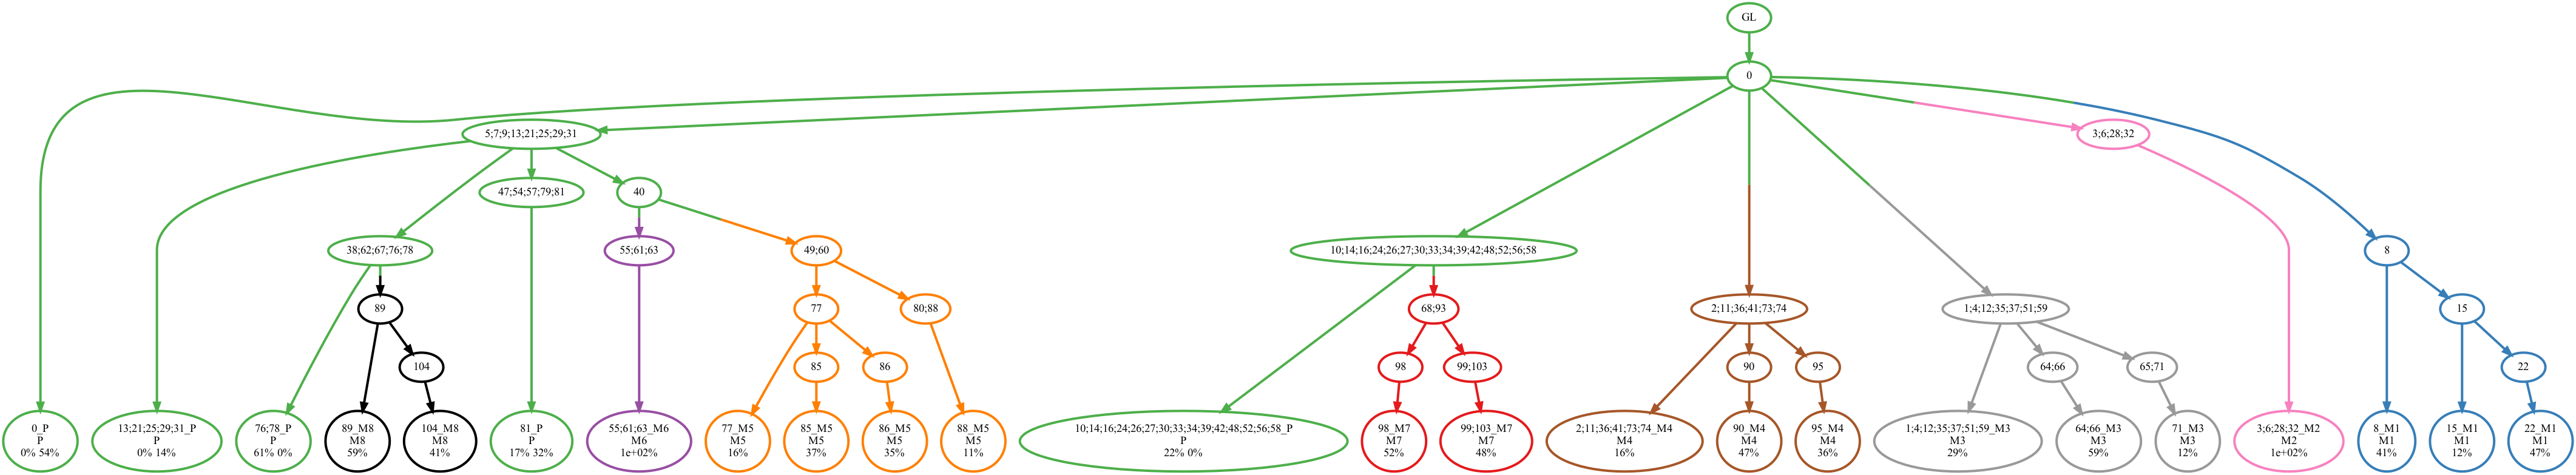

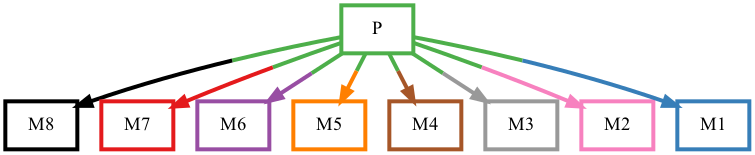

In [12]:
num_sites = "m8"
mig_type = "mS"
SEED = 8
SIM_DATA_DIR = os.path.join(MACHINA_DATA_DIR, num_sites, mig_type)

print("Ground truth")
visualize_ground_truth(os.path.join(SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(SIM_DATA_DIR, f"G_seed{SEED}.dot"))


num trees: 2
TREE 1
G
 None
{0: '0', 1: '8;15;22', 2: '5;7;9;13;21;25;29;31', 3: '3;6;28;32', 4: '40', 5: '10;14;16;24;26;27;30;33;34;39;42;48;52;56;58', 6: '55;61;63', 7: '1;4;12;35;37;51;59;64;66', 8: '65;71', 9: '2;11;36;41;73;74', 10: '49;60;77', 11: '38;62;67;76;78', 12: '47;54;57;79;81', 13: '80;85;86;88', 14: '89', 15: '90;95', 16: '68;93;98;99;103', 17: '104'}
['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']


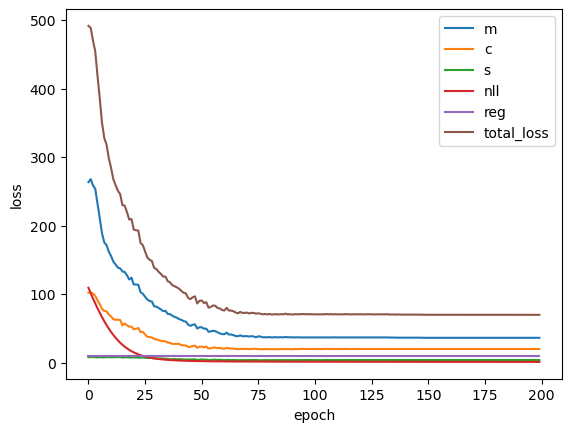

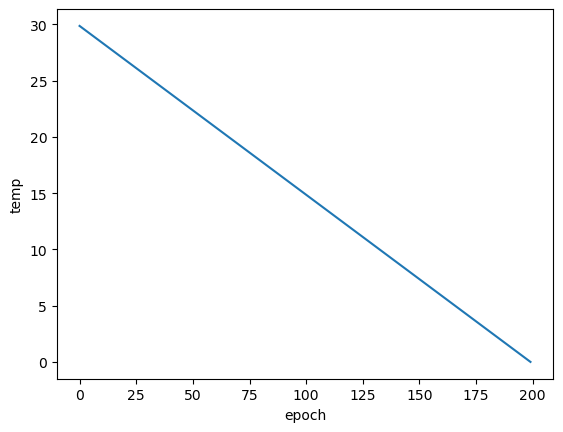

20:46:42 DEBUG

U > 0.05

20:46:42 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.062 0.053 0.069 0.000  0.000  0.000 0.058  0.054 0.083   
M1 0.051 0.067 0.000 0.000 0.000 0.000  0.000  0.072 0.000  0.000 0.000   
M2 0.072 0.056 0.000 0.000 0.000 0.000  0.000  0.076 0.057  0.066 0.079   
M3 0.076 0.062 0.000 0.000 0.051 0.000  0.000  0.073 0.072  0.061 0.000   
M4 0.076 0.053 0.000 0.063 0.056 0.000  0.076  0.000 0.000  0.000 0.000   
M5 0.074 0.066 0.000 0.000 0.000 0.073  0.068  0.069 0.057  0.000 0.000   
M6 0.063 0.000 0.000 0.055 0.050 0.000  0.000  0.000 0.000  0.000 0.061   
M7 0.000 0.059 0.000 0.000 0.000 0.076  0.080  0.079 0.050  0.059 0.000   
M8 0.076 0.000 0.000 0.000 0.000 0.000  0.065  0.065 0.060  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.082  0.000  0.000  0.000 0.000  0.000  0.080 0.076  
M1  0.076  0.053  0.070  0.055 0.066  0.075  0.000 0.000  
M2  0.069  0.000  0.000  0.000 

Time elapsed: 6.135403
print_config.k_best_trees 1
============================== INTERMEDIATE TREE ==============================

Iteration: 0, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.104 0.115 0.109 0.112 0.109   
5;7;9;13;21;25;29;31                         0.116 0.114 0.108 0.113 0.112   
3;6;28;32                                    0.109 0.110 0.118 0.112 0.112   
40                                           0.118 0.113 0.109 0.108 0.108   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.111 0.112 0.108 0.116 0.110   
55;61;63                                     0.113 0.110 0.118 0.104 0.108   
1;4;12;35;37;51;59;64;66                     0.106 0.111 0.109 0.114 0.104   
65;71                                        0.111 0.111 0.112 0.107 0.109   
2;11;36;41;73;74                             0.114 0.106 0.118 0.110 0.105   
49;60;77                             

20:46:43 DEBUG
run [PosixPath('dot'), '-Kdot', '-Tsvg']


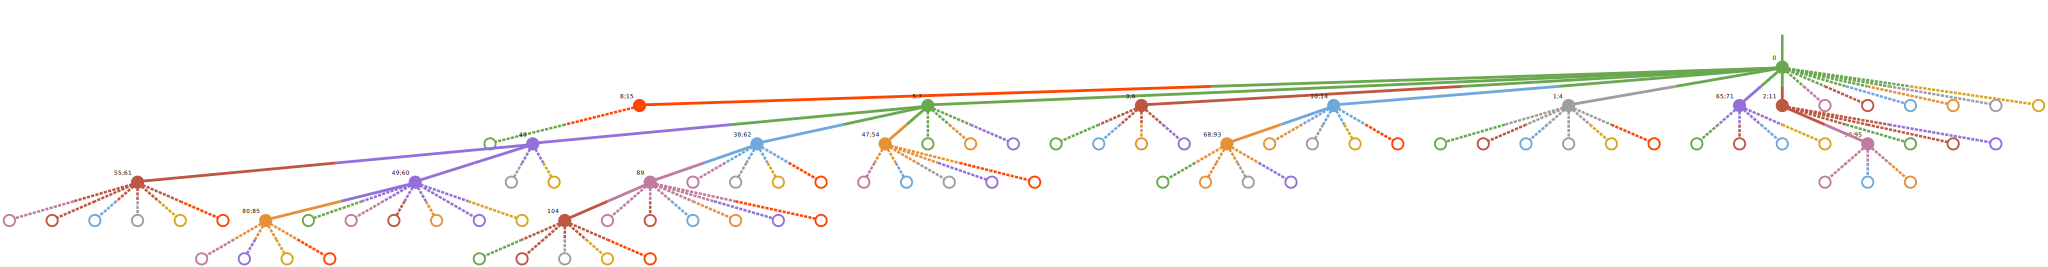

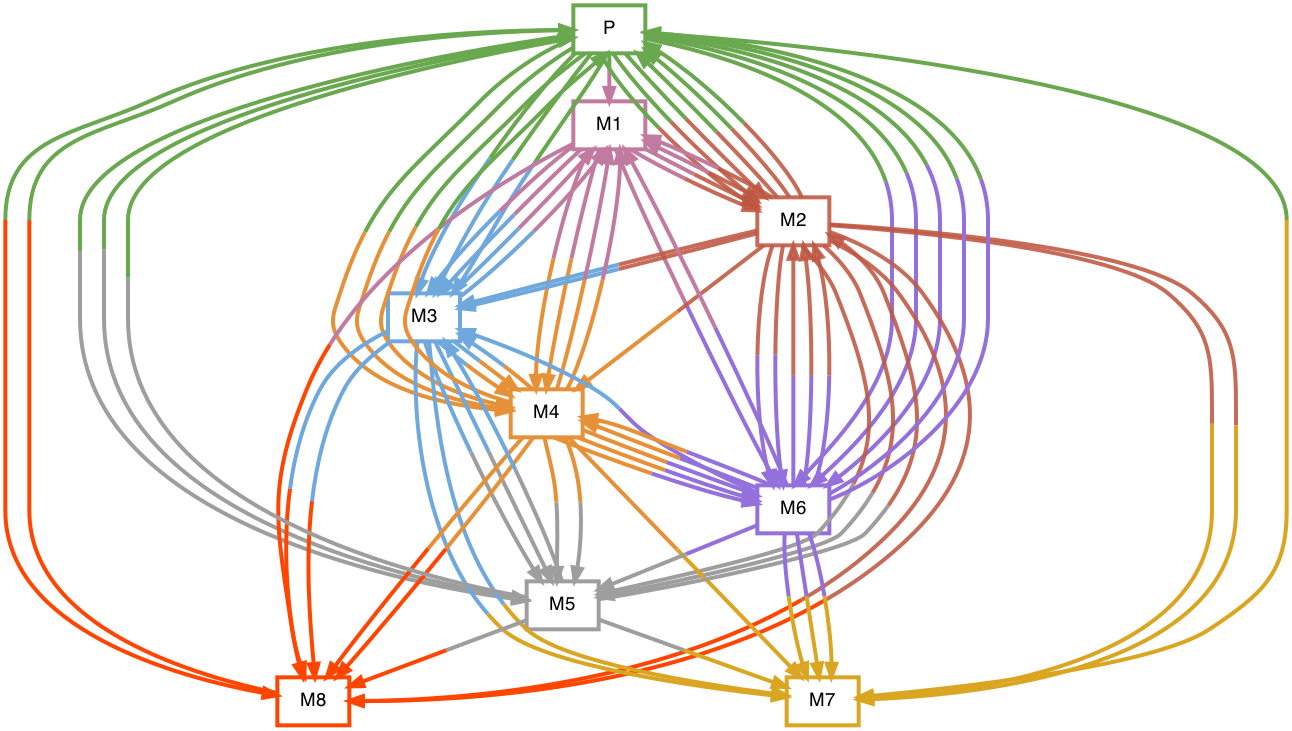

20:46:43 DEBUG

U > 0.05

20:46:43 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.095 0.000 0.000  0.203  0.000 0.000  0.000 0.000   
M1 0.220 0.296 0.197 0.000 0.000 0.000  0.000  0.000 0.000  0.140 0.000   
M2 0.230 0.225 0.000 0.000 0.295 0.000  0.000  0.000 0.000  0.096 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.693  0.061 0.000   
M4 0.076 0.058 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.346   
M5 0.000 0.000 0.000 0.073 0.000 0.260  0.000  0.078 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.224 0.000 0.233  0.000  0.267 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.521  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.129  0.144  0.000 0.121  0.000  0.000 0.205  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 20, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.128 0.119 0.117 0.103 0.106   
5;7;9;13;21;25;29;31                         0.122 0.105 0.101 0.112 0.122   
3;6;28;32                                    0.121 0.116 0.119 0.108 0.115   
40                                           0.110 0.106 0.112 0.110 0.100   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.118 0.112 0.106 0.102 0.116   
55;61;63                                     0.103 0.110 0.112 0.110 0.107   
1;4;12;35;37;51;59;64;66                     0.114 0.104 0.113 0.133 0.107   
65;71                                        0.110 0.111 0.121 0.117 0.112   
2;11;36;41;73;74                             0.125 0.117 0.118 0.108 0.117   
49;60;77                                     0.111 0.115 0.109 0.107 0.106   
38;62;67;

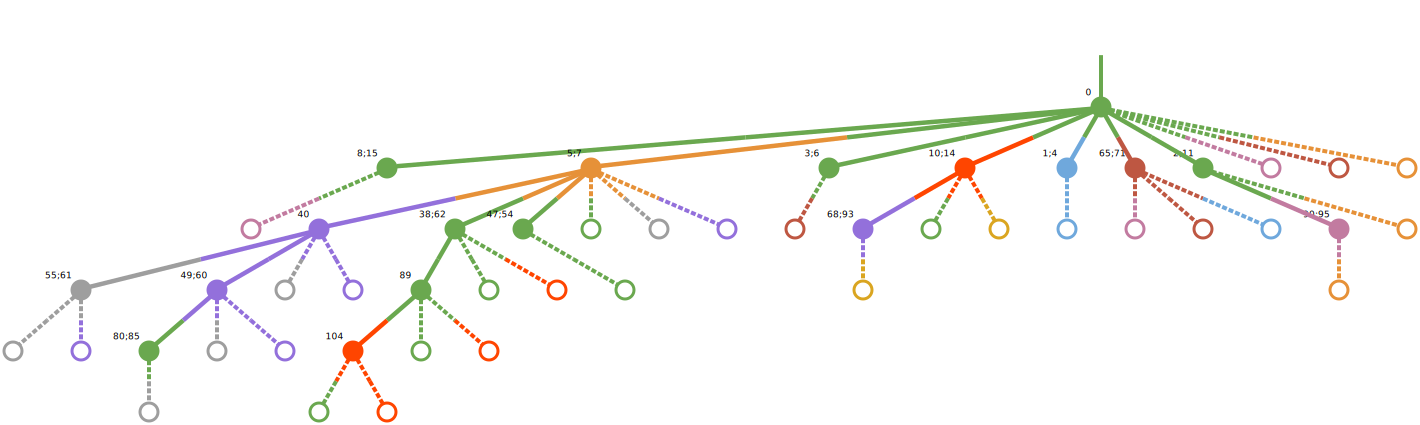

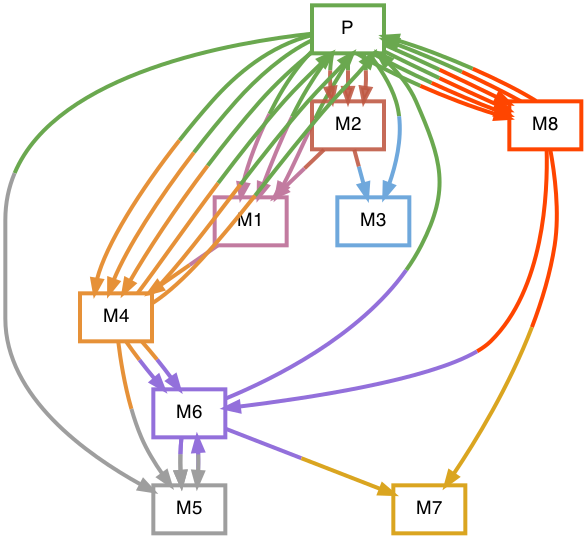

20:46:44 DEBUG

U > 0.05

20:46:44 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.057 0.000 0.000  0.208  0.000 0.000  0.000 0.000   
M1 0.157 0.263 0.526 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.055 0.000 0.000 0.849 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.901  0.050 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.487   
M5 0.000 0.000 0.000 0.000 0.000 0.096  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.055 0.000 0.092  0.000  0.795 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.422  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.305  0.178  0.000 0.120  0.000  0.000 0.105  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 40, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.143 0.139 0.117 0.091 0.112   
5;7;9;13;21;25;29;31                         0.131 0.103 0.101 0.101 0.111   
3;6;28;32                                    0.126 0.116 0.135 0.098 0.116   
40                                           0.111 0.101 0.101 0.091 0.104   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.133 0.106 0.095 0.097 0.114   
55;61;63                                     0.101 0.107 0.115 0.109 0.101   
1;4;12;35;37;51;59;64;66                     0.126 0.115 0.102 0.136 0.099   
65;71                                        0.125 0.118 0.150 0.116 0.107   
2;11;36;41;73;74                             0.137 0.116 0.110 0.107 0.130   
49;60;77                                     0.111 0.109 0.111 0.095 0.111   
38;62;67;

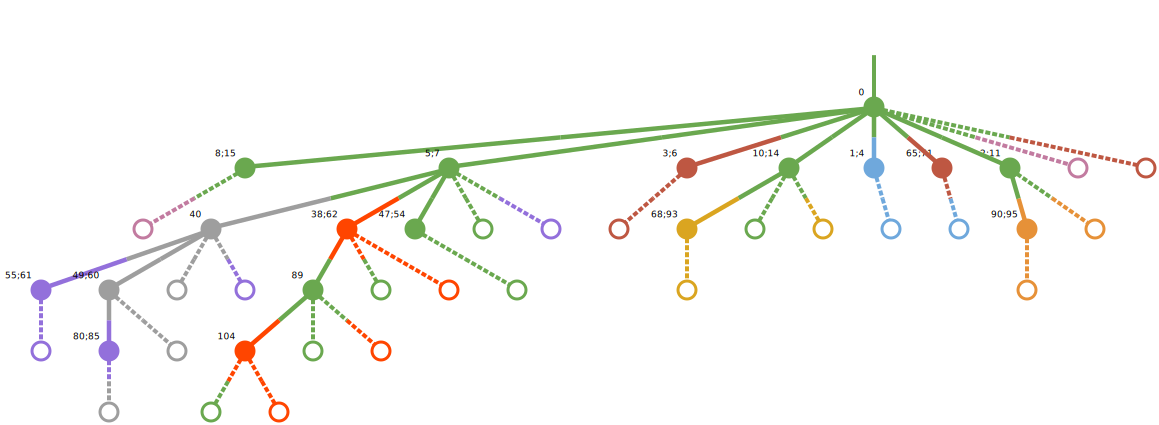

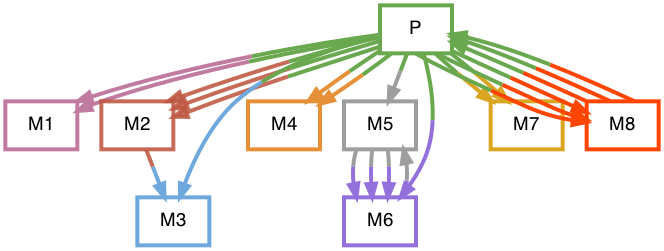

20:46:45 DEBUG

U > 0.05

20:46:45 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.211  0.000 0.000  0.000 0.000   
M1 0.102 0.197 0.679 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.935 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.866  0.107 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.556   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.911 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.298  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.501  0.164  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 60, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.158 0.150 0.128 0.089 0.099   
5;7;9;13;21;25;29;31                         0.154 0.099 0.104 0.093 0.109   
3;6;28;32                                    0.138 0.127 0.164 0.096 0.110   
40                                           0.100 0.098 0.091 0.088 0.095   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.147 0.099 0.089 0.095 0.111   
55;61;63                                     0.091 0.121 0.101 0.097 0.087   
1;4;12;35;37;51;59;64;66                     0.145 0.094 0.093 0.167 0.099   
65;71                                        0.155 0.123 0.141 0.141 0.097   
2;11;36;41;73;74                             0.130 0.123 0.112 0.104 0.153   
49;60;77                                     0.090 0.102 0.106 0.101 0.094   
38;62;67;

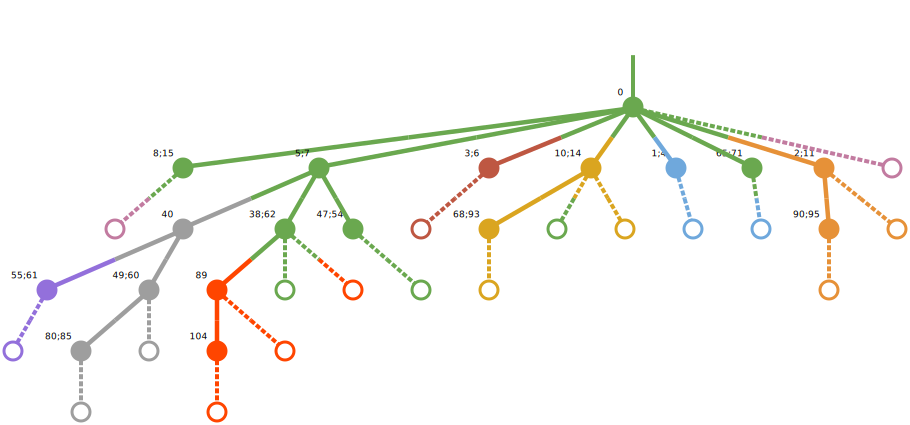

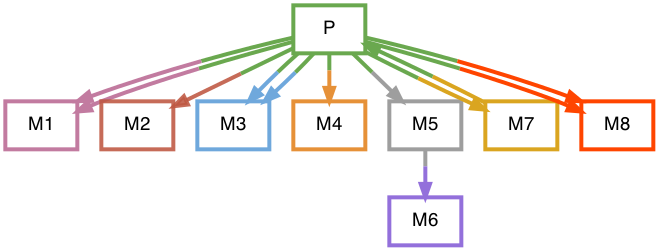

20:46:45 DEBUG

U > 0.05

20:46:45 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.213  0.000 0.000  0.000 0.000   
M1 0.110 0.241 0.635 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.951 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.892  0.088 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.596   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.931 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.260  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.550  0.176  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 80, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.177 0.196 0.113 0.084 0.097   
5;7;9;13;21;25;29;31                         0.216 0.094 0.089 0.092 0.100   
3;6;28;32                                    0.161 0.122 0.205 0.092 0.088   
40                                           0.099 0.107 0.085 0.082 0.083   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.176 0.084 0.087 0.091 0.101   
55;61;63                                     0.080 0.099 0.084 0.113 0.090   
1;4;12;35;37;51;59;64;66                     0.169 0.092 0.093 0.203 0.087   
65;71                                        0.172 0.117 0.122 0.178 0.082   
2;11;36;41;73;74                             0.131 0.105 0.108 0.096 0.202   
49;60;77                                     0.092 0.089 0.091 0.095 0.093   
38;62;67;

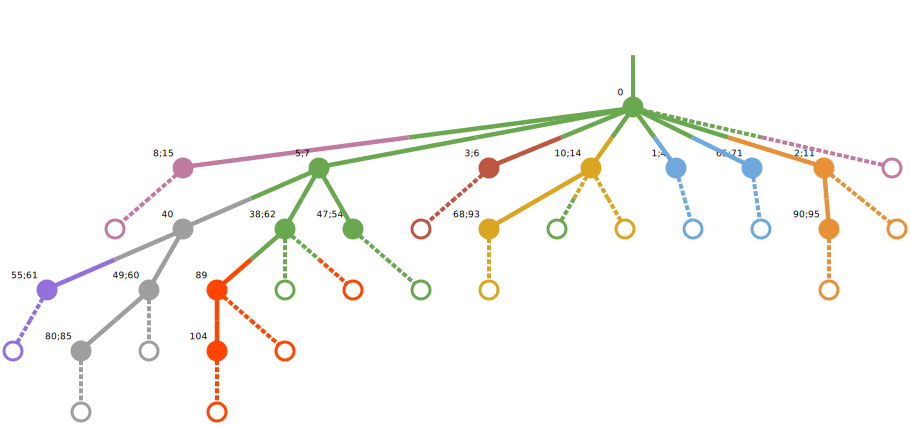

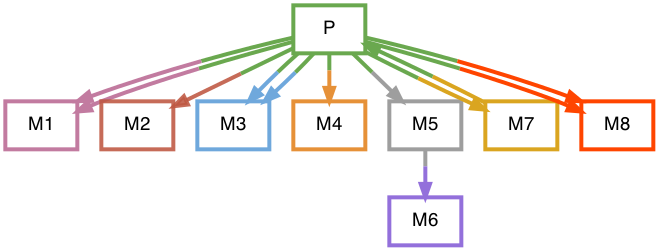

20:46:46 DEBUG

U > 0.05

20:46:46 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.214  0.000 0.000  0.000 0.000   
M1 0.111 0.264 0.614 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.958 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.887  0.096 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.608   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.938 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.255  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.564  0.181  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 100, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.193 0.271 0.121 0.061 0.074   
5;7;9;13;21;25;29;31                         0.329 0.079 0.078 0.083 0.086   
3;6;28;32                                    0.198 0.106 0.267 0.068 0.070   
40                                           0.088 0.075 0.078 0.065 0.063   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.206 0.063 0.067 0.083 0.089   
55;61;63                                     0.094 0.082 0.079 0.077 0.083   
1;4;12;35;37;51;59;64;66                     0.190 0.061 0.081 0.325 0.067   
65;71                                        0.227 0.116 0.104 0.206 0.066   
2;11;36;41;73;74                             0.116 0.104 0.095 0.087 0.320   
49;60;77                                     0.077 0.073 0.090 0.077 0.070   
38;62;67

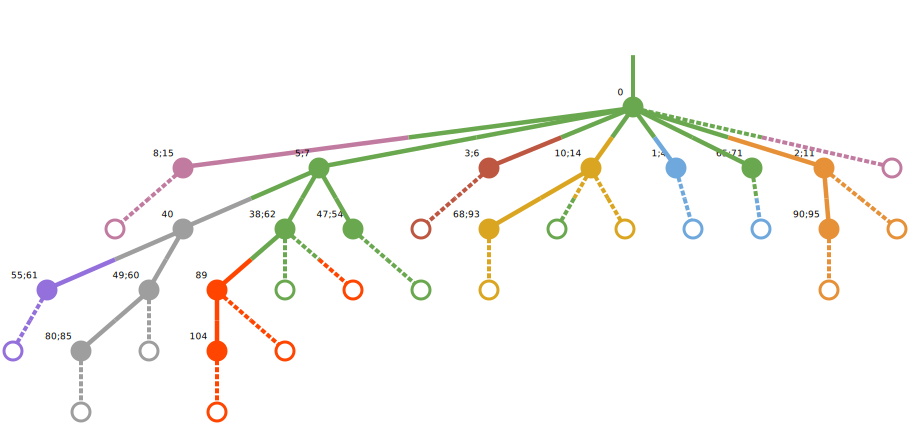

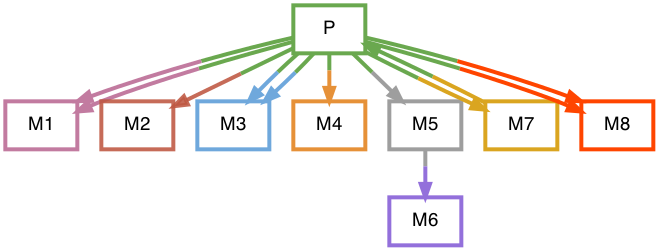

20:46:46 DEBUG

U > 0.05

20:46:46 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.214  0.000 0.000  0.000 0.000   
M1 0.106 0.260 0.625 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.962 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.891  0.095 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.607   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.942 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.260  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.573  0.182  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 120, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.237 0.413 0.071 0.043 0.053   
5;7;9;13;21;25;29;31                         0.552 0.052 0.051 0.056 0.063   
3;6;28;32                                    0.202 0.072 0.409 0.059 0.062   
40                                           0.097 0.045 0.044 0.049 0.047   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.270 0.038 0.040 0.040 0.060   
55;61;63                                     0.062 0.054 0.061 0.050 0.058   
1;4;12;35;37;51;59;64;66                     0.190 0.048 0.053 0.476 0.044   
65;71                                        0.213 0.093 0.086 0.354 0.052   
2;11;36;41;73;74                             0.084 0.067 0.073 0.049 0.538   
49;60;77                                     0.040 0.052 0.046 0.041 0.046   
38;62;67

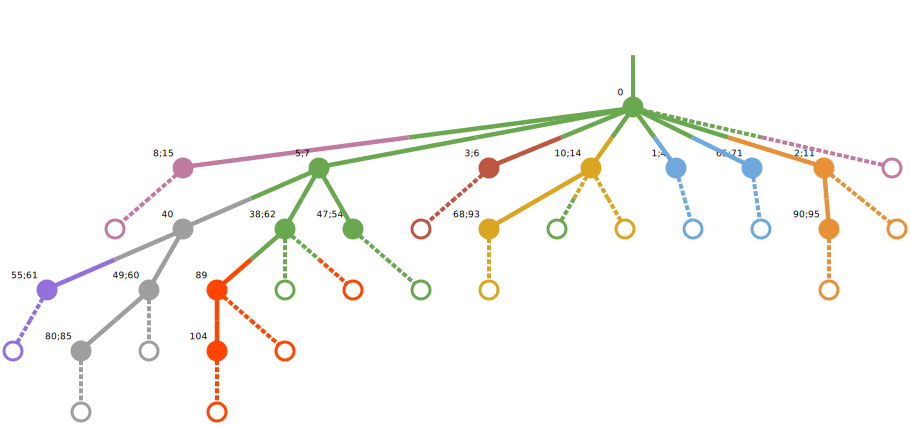

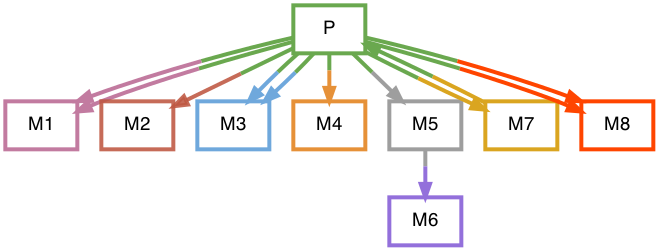

20:46:47 DEBUG

U > 0.05

20:46:47 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.215  0.000 0.000  0.000 0.000   
M1 0.105 0.264 0.624 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.965 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.892  0.096 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.605   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.944 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.267  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.578  0.183  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 140, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.163 0.681 0.036 0.018 0.028   
5;7;9;13;21;25;29;31                         0.848 0.015 0.015 0.019 0.020   
3;6;28;32                                    0.130 0.036 0.729 0.015 0.019   
40                                           0.026 0.016 0.015 0.018 0.014   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.139 0.015 0.017 0.015 0.026   
55;61;63                                     0.027 0.024 0.023 0.023 0.031   
1;4;12;35;37;51;59;64;66                     0.105 0.019 0.017 0.777 0.016   
65;71                                        0.212 0.040 0.045 0.594 0.028   
2;11;36;41;73;74                             0.042 0.029 0.028 0.026 0.812   
49;60;77                                     0.016 0.017 0.017 0.014 0.021   
38;62;67

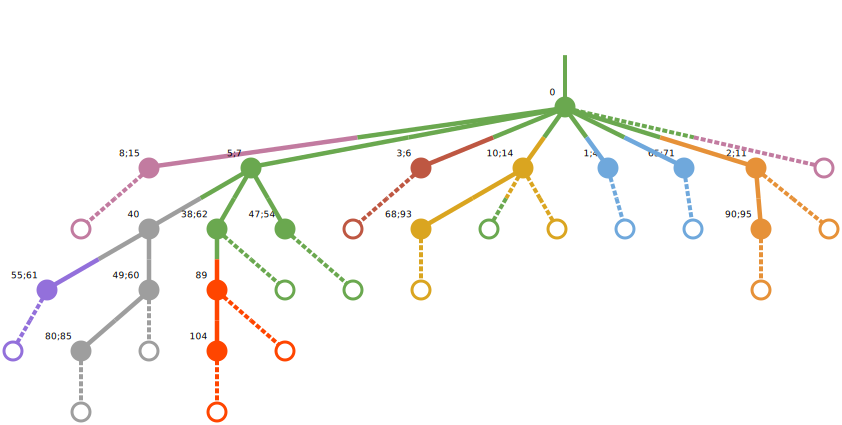

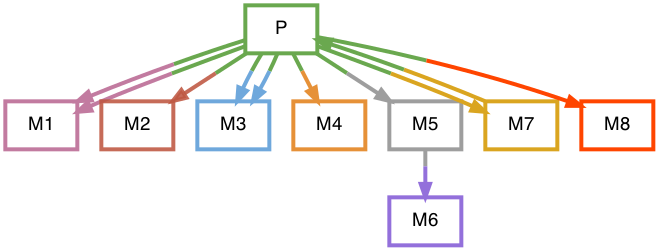

20:46:47 DEBUG

U > 0.05

20:46:47 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.215  0.000 0.000  0.000 0.000   
M1 0.104 0.266 0.624 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.967 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.893  0.096 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.605   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.944 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.272  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.582  0.183  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 160, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.042 0.944 0.003 0.002 0.002   
5;7;9;13;21;25;29;31                         0.981 0.002 0.002 0.002 0.004   
3;6;28;32                                    0.030 0.008 0.948 0.003 0.003   
40                                           0.003 0.001 0.001 0.001 0.001   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.033 0.002 0.002 0.001 0.003   
55;61;63                                     0.006 0.004 0.003 0.003 0.004   
1;4;12;35;37;51;59;64;66                     0.018 0.002 0.001 0.971 0.001   
65;71                                        0.056 0.007 0.005 0.919 0.005   
2;11;36;41;73;74                             0.007 0.003 0.003 0.002 0.980   
49;60;77                                     0.001 0.001 0.001 0.001 0.001   
38;62;67

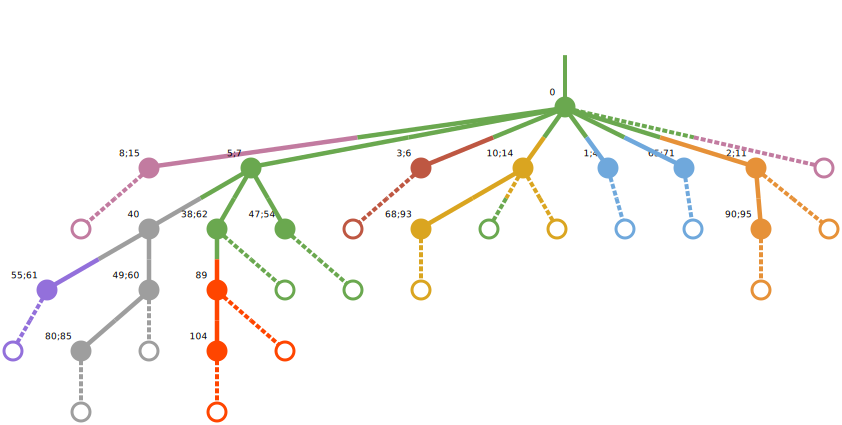

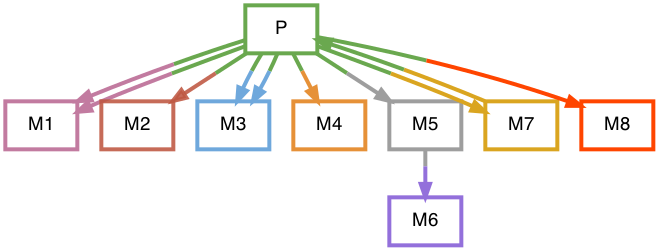

20:46:48 DEBUG

U > 0.05

20:46:48 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.215  0.000 0.000  0.000 0.000   
M1 0.104 0.267 0.625 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.969 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.894  0.096 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.605   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.944 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.276  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.584  0.184  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 180, Intermediate best tree idx 9
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.001 0.999 0.000 0.000 0.000   
5;7;9;13;21;25;29;31                         1.000 0.000 0.000 0.000 0.000   
3;6;28;32                                    0.000 0.000 0.999 0.000 0.000   
40                                           0.000 0.000 0.000 0.000 0.000   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.000 0.000 0.000 0.000 0.000   
55;61;63                                     0.000 0.000 0.000 0.000 0.000   
1;4;12;35;37;51;59;64;66                     0.001 0.000 0.000 0.999 0.000   
65;71                                        0.003 0.000 0.000 0.997 0.000   
2;11;36;41;73;74                             0.000 0.000 0.000 0.000 1.000   
49;60;77                                     0.000 0.000 0.000 0.000 0.000   
38;62;67

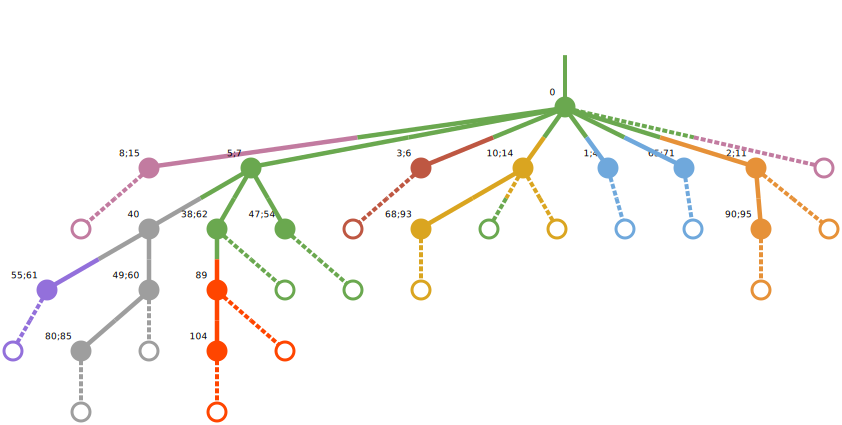

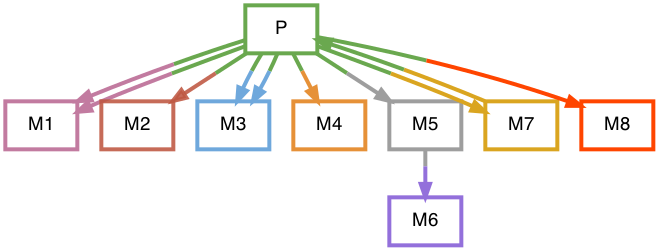

20:46:48 DEBUG

U > 0.05

20:46:48 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.215  0.000 0.000  0.000 0.000   
M1 0.104 0.267 0.625 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.969 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.894  0.096 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.605   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.944 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.276  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.584  0.184  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

****************************** BEST TREE ******************************

Migration number: 11.0
Comigration number: 9.0
Seeding site number: 3.0
Neg log likelihood: 0.771
Reg: 8.792218208312988
Loss: 63.563


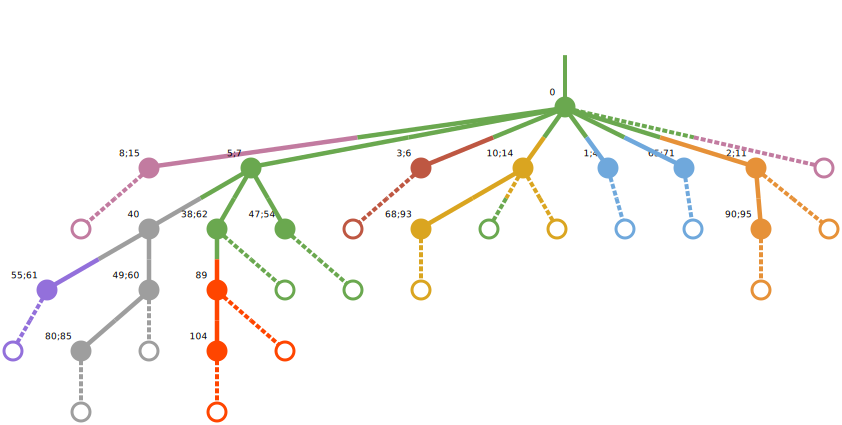

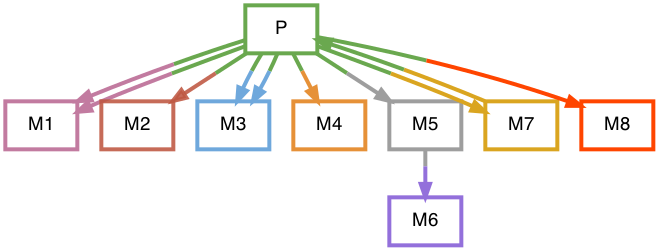

20:46:49 DEBUG
run [PosixPath('dot'), '-Kdot', '-Tsvg']


0 #6aa84fff;1.0:
8;15 #c27ba0ff;1.0:
0 8;15 0.06249999941792339 1.9999999999999998
0 #6aa84fff;1.0:
5;7 #6aa84fff;0.7364310026168823:#9370dbff;0.26356905698776245:
0 5;7 0.06249999941792339 2.5
0 #6aa84fff;1.0:
3;6 #be5742ff;1.0:
0 3;6 0.06249999941792339 2.5
0 #6aa84fff;1.0:
10;14 #daa520ff;0.38220715522766113:#6aa84fff;0.6177927851676941:
0 10;14 0.06249999941792339 2.5
0 #6aa84fff;1.0:
1;4 #6fa8dcff;1.0:
0 1;4 0.06249999941792339 2.5
0 #6aa84fff;1.0:
65;71 #6fa8dcff;1.0:
0 65;71 0.06249999941792339 2.5
0 #6aa84fff;1.0:
2;11 #e69138ff;1.0:
0 2;11 0.06249999941792339 2.5
0 #6aa84fff;1.0:
0_M1 #c27ba0ff;1.0:
0 0_M1 0.06249999941792339 2.5
8;15 #c27ba0ff;1.0:
8_M1 #c27ba0ff;1.0:
8;15 8_M1 0.06249999941792339 2.5
5;7 #6aa84fff;0.7364310026168823:#9370dbff;0.26356905698776245:
40 #9e9e9eff;0.6042566299438477:#9370dbff;0.39574337005615234:
5;7 40 0.06249999941792339 2.5
5;7 #6aa84fff;0.7364310026168823:#9370dbff;0.26356905698776245:
38;62 #6aa84fff;0.7503470182418823:#ff4500ff;0.2496529817

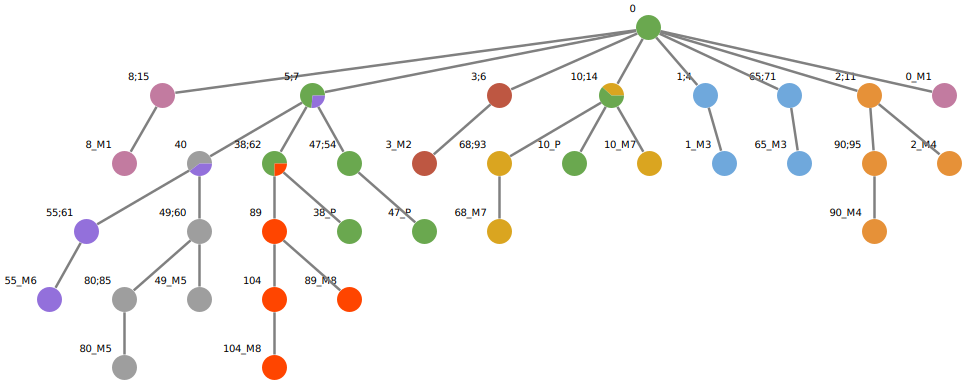

****************************************************************************************************
TREE 2
G
 None
{0: '0', 1: '8;15;22', 2: '5;7;9;13;21;25;29;31', 3: '3;6;28;32', 4: '40', 5: '10;14;16;24;26;27;30;33;34;39;42;48;52;56;58', 6: '55;61;63', 7: '1;4;12;35;37;51;59;64;66', 8: '65;71', 9: '2;11;36;41;73;74', 10: '49;60;77', 11: '38;62;67;76;78', 12: '47;54;57;79;81', 13: '80;85;86;88', 14: '89', 15: '90;95', 16: '68;93;98;99;103', 17: '104'}
['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']


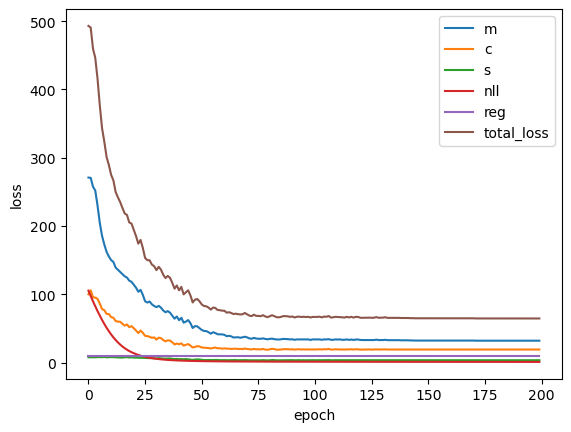

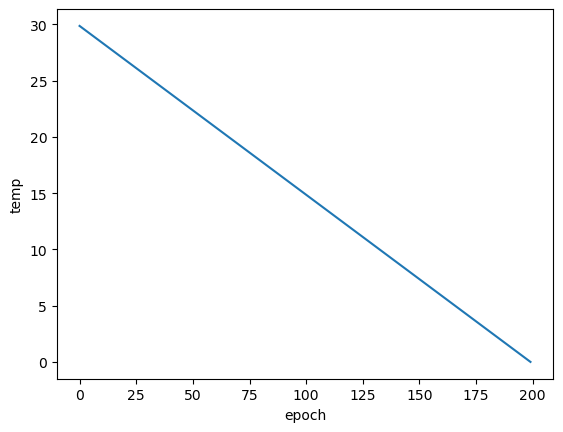

20:46:55 DEBUG

U > 0.05

20:46:55 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.061 0.000 0.000 0.083  0.000  0.066 0.051  0.000 0.086   
M1 0.055 0.000 0.051 0.071 0.000 0.072  0.000  0.083 0.000  0.055 0.066   
M2 0.057 0.000 0.000 0.000 0.000 0.000  0.000  0.060 0.073  0.063 0.056   
M3 0.070 0.069 0.000 0.000 0.069 0.000  0.000  0.054 0.067  0.000 0.068   
M4 0.054 0.000 0.052 0.059 0.055 0.000  0.080  0.076 0.000  0.000 0.000   
M5 0.000 0.058 0.050 0.000 0.084 0.056  0.000  0.000 0.067  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.060 0.000  0.069  0.000 0.073  0.000 0.063   
M7 0.055 0.063 0.080 0.056 0.000 0.000  0.000  0.000 0.076  0.055 0.075   
M8 0.000 0.000 0.000 0.000 0.056 0.000  0.062  0.000 0.064  0.000 0.069   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.069  0.000  0.000 0.066  0.000  0.057 0.072  
M1  0.064  0.072  0.000  0.000 0.050  0.000  0.000 0.000  
M2  0.053  0.060  0.070  0.084 

Time elapsed: 5.850297
print_config.k_best_trees 1
============================== INTERMEDIATE TREE ==============================

Iteration: 0, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.107 0.116 0.108 0.108 0.110   
5;7;9;13;21;25;29;31                         0.116 0.107 0.114 0.109 0.118   
3;6;28;32                                    0.109 0.113 0.110 0.108 0.114   
40                                           0.110 0.110 0.108 0.112 0.106   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.110 0.120 0.119 0.107 0.109   
55;61;63                                     0.107 0.137 0.105 0.107 0.112   
1;4;12;35;37;51;59;64;66                     0.115 0.108 0.111 0.111 0.110   
65;71                                        0.111 0.111 0.108 0.107 0.114   
2;11;36;41;73;74                             0.110 0.106 0.115 0.113 0.112   
49;60;77                             

20:46:56 DEBUG
run [PosixPath('dot'), '-Kdot', '-Tsvg']


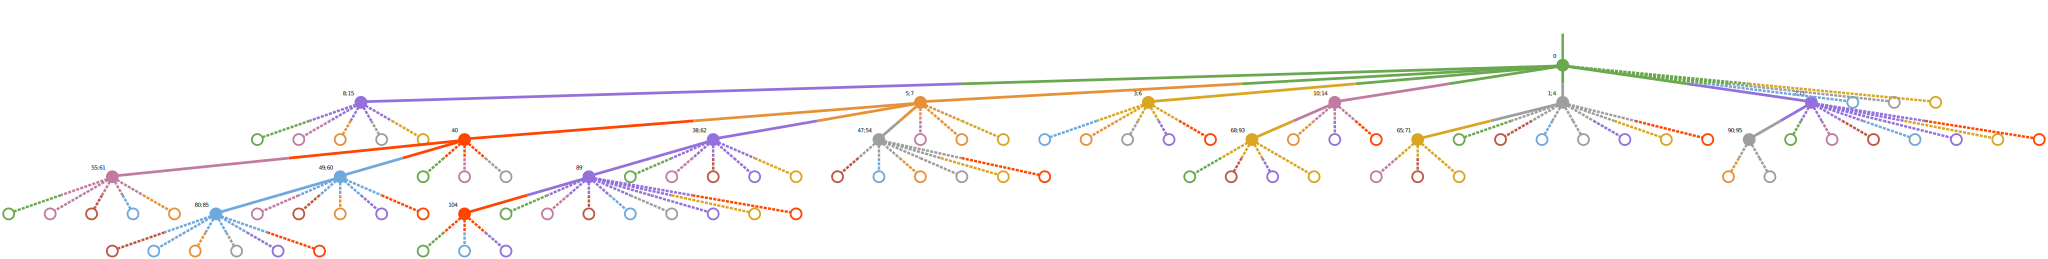

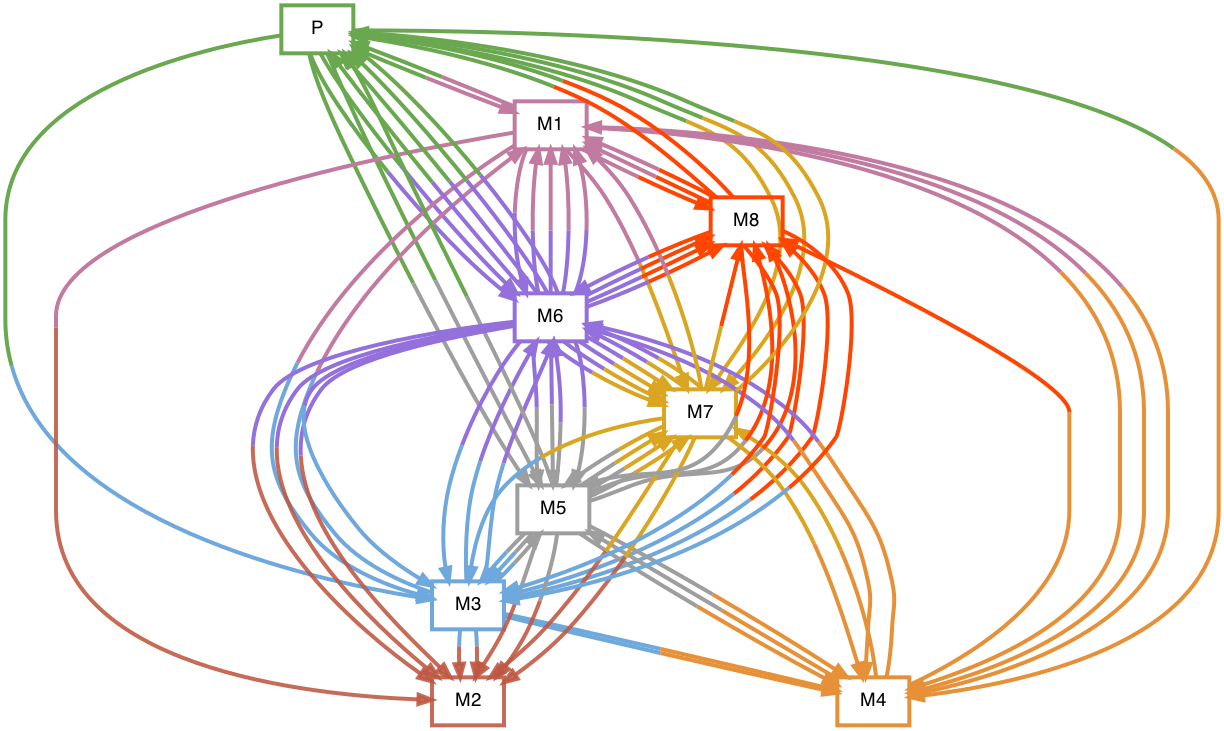

20:46:56 DEBUG

U > 0.05

20:46:56 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.086 0.000 0.000  0.152  0.000 0.000  0.000 0.000   
M1 0.292 0.226 0.277 0.000 0.076 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.296 0.210 0.080 0.000 0.263 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.052 0.000 0.000 0.000 0.000  0.000  0.000 0.462  0.307 0.000   
M4 0.081 0.062 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.250   
M5 0.000 0.000 0.000 0.078 0.000 0.199  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.176 0.000 0.255  0.000  0.253 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.295  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.056 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.219  0.136  0.000 0.163  0.000  0.000 0.131  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 20, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.119 0.115 0.113 0.099 0.108   
5;7;9;13;21;25;29;31                         0.112 0.116 0.105 0.110 0.109   
3;6;28;32                                    0.116 0.118 0.109 0.112 0.113   
40                                           0.107 0.121 0.105 0.107 0.103   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.124 0.109 0.112 0.105 0.113   
55;61;63                                     0.103 0.118 0.105 0.106 0.116   
1;4;12;35;37;51;59;64;66                     0.113 0.106 0.122 0.117 0.102   
65;71                                        0.108 0.108 0.114 0.123 0.111   
2;11;36;41;73;74                             0.113 0.111 0.113 0.104 0.122   
49;60;77                                     0.103 0.115 0.105 0.110 0.115   
38;62;67;

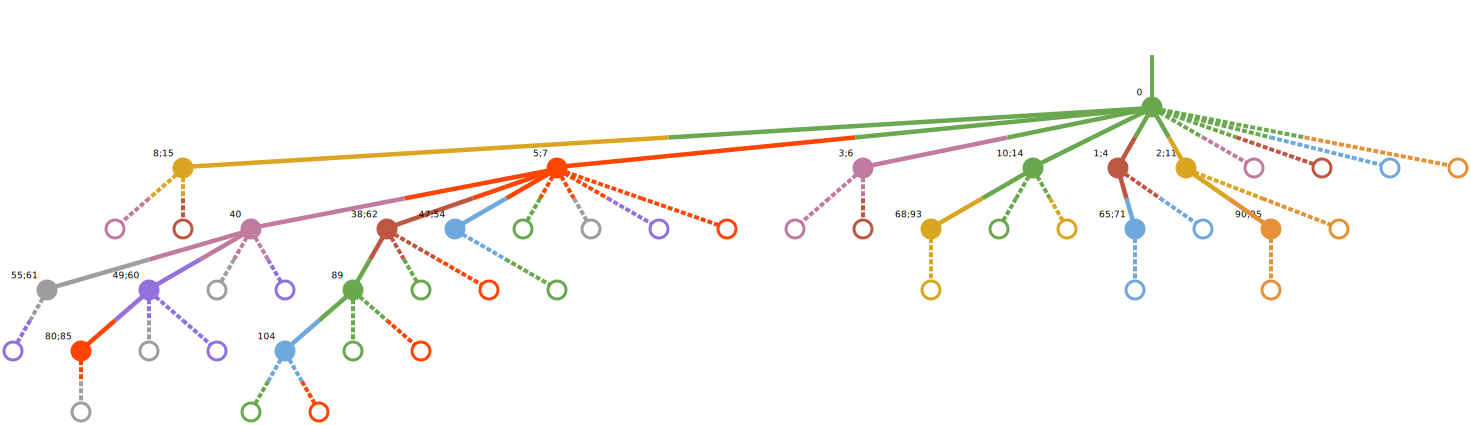

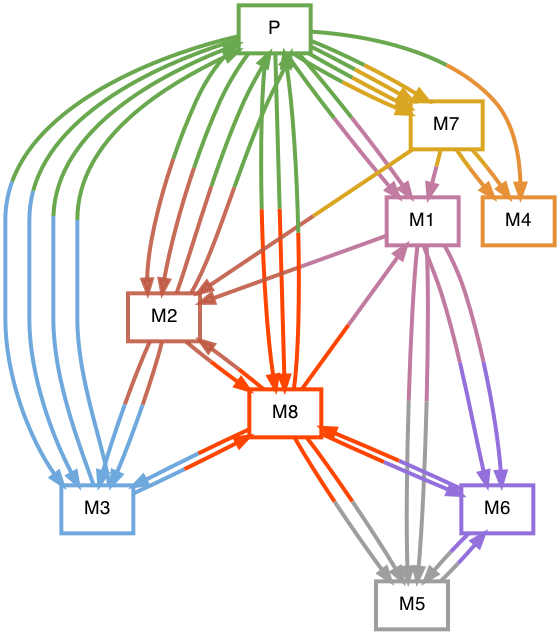

20:46:57 DEBUG

U > 0.05

20:46:57 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.200  0.000 0.000  0.000 0.000   
M1 0.199 0.222 0.550 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.071 0.070 0.000 0.000 0.815 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.651  0.289 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.388   
M5 0.000 0.000 0.000 0.000 0.000 0.126  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.051 0.000 0.123  0.000  0.766 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.310  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.432  0.173  0.000 0.094  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 40, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.122 0.134 0.124 0.102 0.116   
5;7;9;13;21;25;29;31                         0.126 0.105 0.098 0.113 0.101   
3;6;28;32                                    0.133 0.121 0.127 0.107 0.103   
40                                           0.109 0.119 0.098 0.102 0.106   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.143 0.101 0.106 0.097 0.109   
55;61;63                                     0.103 0.122 0.113 0.105 0.106   
1;4;12;35;37;51;59;64;66                     0.108 0.101 0.136 0.154 0.095   
65;71                                        0.102 0.118 0.114 0.136 0.099   
2;11;36;41;73;74                             0.122 0.110 0.120 0.106 0.126   
49;60;77                                     0.104 0.101 0.108 0.101 0.104   
38;62;67;

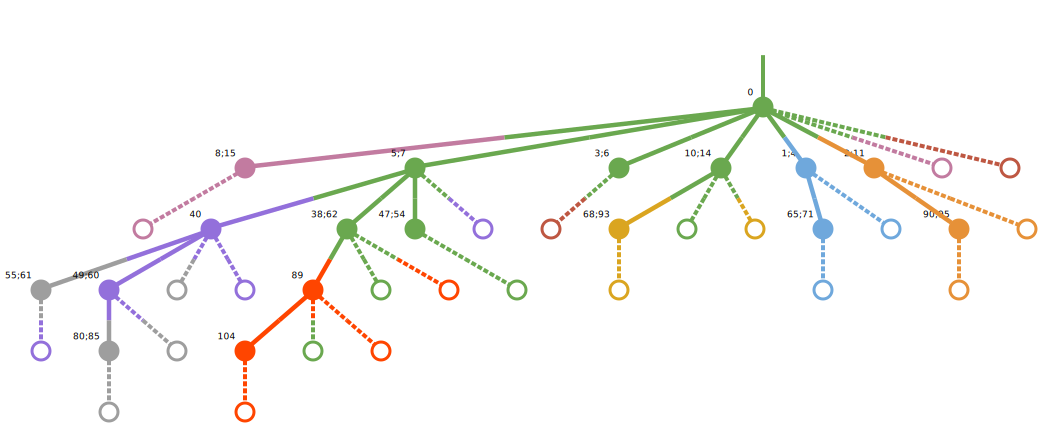

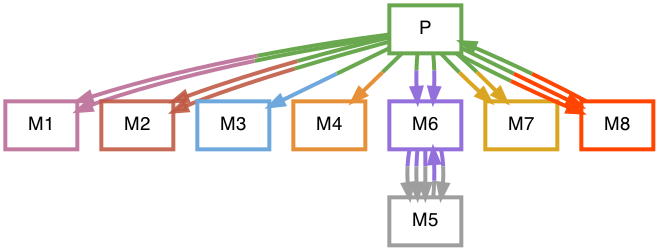

20:46:58 DEBUG

U > 0.05

20:46:58 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.213  0.000 0.000  0.000 0.000   
M1 0.129 0.191 0.667 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.926 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.765  0.193 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.515   
M5 0.000 0.000 0.000 0.000 0.000 0.057  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.905 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.280  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.532  0.177  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 60, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.126 0.169 0.112 0.083 0.109   
5;7;9;13;21;25;29;31                         0.153 0.108 0.105 0.099 0.094   
3;6;28;32                                    0.158 0.132 0.149 0.092 0.103   
40                                           0.115 0.130 0.091 0.087 0.091   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.174 0.092 0.097 0.083 0.109   
55;61;63                                     0.097 0.115 0.094 0.100 0.114   
1;4;12;35;37;51;59;64;66                     0.118 0.104 0.116 0.159 0.092   
65;71                                        0.106 0.113 0.114 0.161 0.090   
2;11;36;41;73;74                             0.145 0.119 0.111 0.091 0.140   
49;60;77                                     0.083 0.111 0.101 0.106 0.102   
38;62;67;

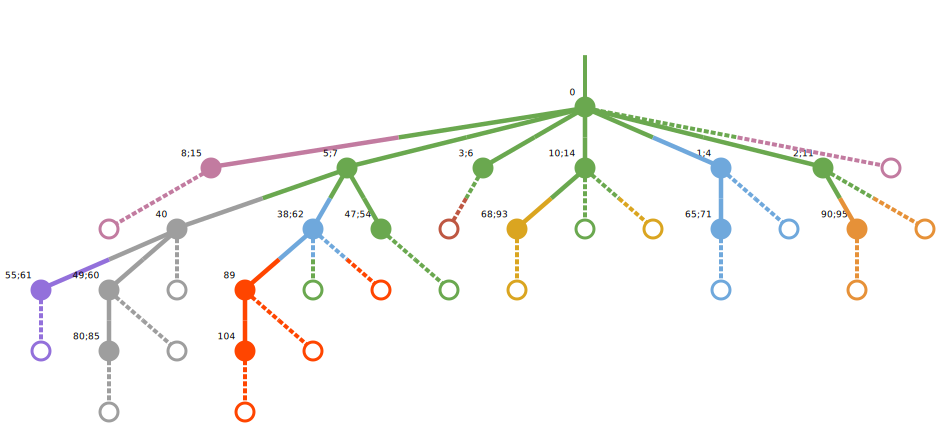

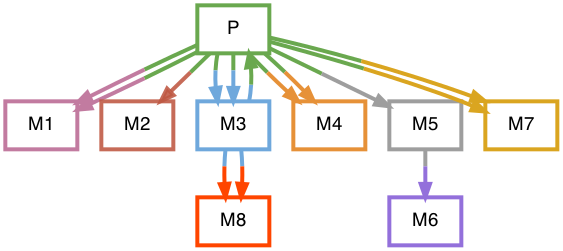

20:46:58 DEBUG

U > 0.05

20:46:58 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.212  0.000 0.000  0.000 0.000   
M1 0.125 0.240 0.627 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.946 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.819  0.141 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.602   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.929 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.269  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.566  0.177  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 80, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.144 0.192 0.123 0.083 0.092   
5;7;9;13;21;25;29;31                         0.200 0.094 0.083 0.094 0.089   
3;6;28;32                                    0.173 0.106 0.178 0.103 0.091   
40                                           0.087 0.109 0.083 0.085 0.086   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.215 0.084 0.082 0.087 0.092   
55;61;63                                     0.089 0.115 0.086 0.097 0.096   
1;4;12;35;37;51;59;64;66                     0.113 0.090 0.113 0.206 0.082   
65;71                                        0.089 0.099 0.115 0.220 0.089   
2;11;36;41;73;74                             0.136 0.114 0.110 0.091 0.186   
49;60;77                                     0.066 0.089 0.125 0.087 0.088   
38;62;67;

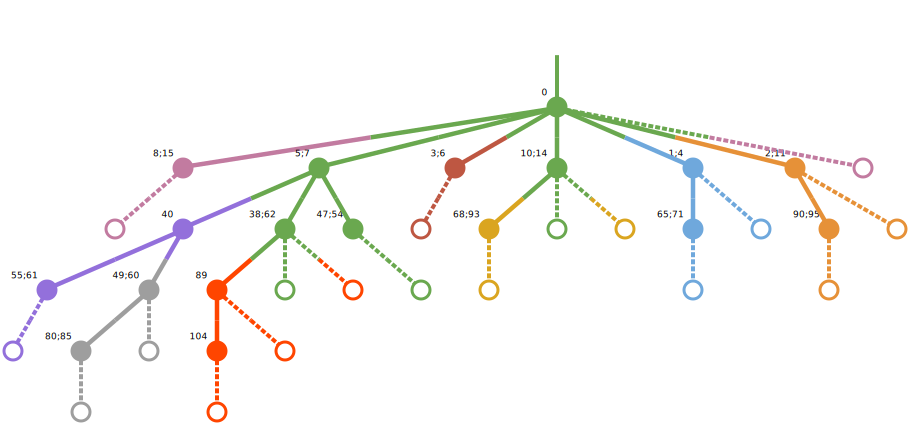

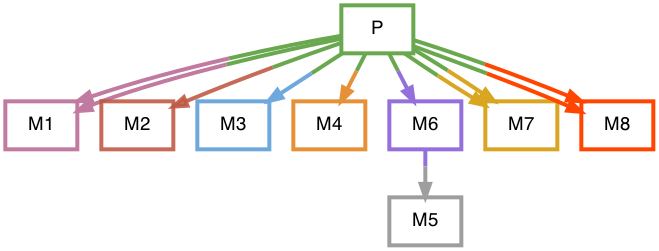

20:46:59 DEBUG

U > 0.05

20:46:59 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.214  0.000 0.000  0.000 0.000   
M1 0.117 0.260 0.616 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.953 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.837  0.120 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.623   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.936 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.268  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.573  0.182  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 100, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.171 0.259 0.117 0.064 0.106   
5;7;9;13;21;25;29;31                         0.337 0.096 0.059 0.086 0.073   
3;6;28;32                                    0.200 0.099 0.262 0.078 0.070   
40                                           0.092 0.092 0.067 0.072 0.070   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.275 0.059 0.067 0.057 0.070   
55;61;63                                     0.090 0.118 0.071 0.072 0.080   
1;4;12;35;37;51;59;64;66                     0.095 0.080 0.081 0.366 0.071   
65;71                                        0.072 0.090 0.095 0.370 0.067   
2;11;36;41;73;74                             0.124 0.110 0.106 0.080 0.270   
49;60;77                                     0.066 0.101 0.074 0.076 0.085   
38;62;67

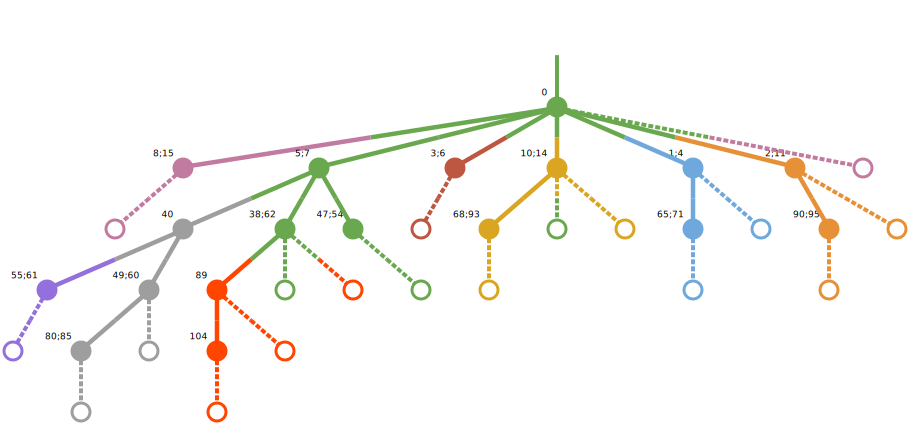

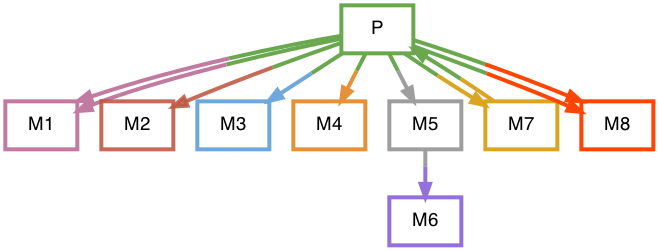

20:46:59 DEBUG

U > 0.05

20:46:59 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.214  0.000 0.000  0.000 0.000   
M1 0.109 0.260 0.625 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.958 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.836  0.113 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.616   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.940 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.273  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.579  0.183  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 120, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.151 0.469 0.072 0.043 0.063   
5;7;9;13;21;25;29;31                         0.584 0.054 0.041 0.048 0.045   
3;6;28;32                                    0.228 0.077 0.377 0.054 0.053   
40                                           0.065 0.067 0.053 0.043 0.050   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.441 0.030 0.033 0.030 0.042   
55;61;63                                     0.057 0.086 0.059 0.057 0.062   
1;4;12;35;37;51;59;64;66                     0.073 0.065 0.063 0.507 0.050   
65;71                                        0.046 0.073 0.066 0.576 0.044   
2;11;36;41;73;74                             0.094 0.078 0.078 0.052 0.466   
49;60;77                                     0.040 0.050 0.052 0.043 0.041   
38;62;67

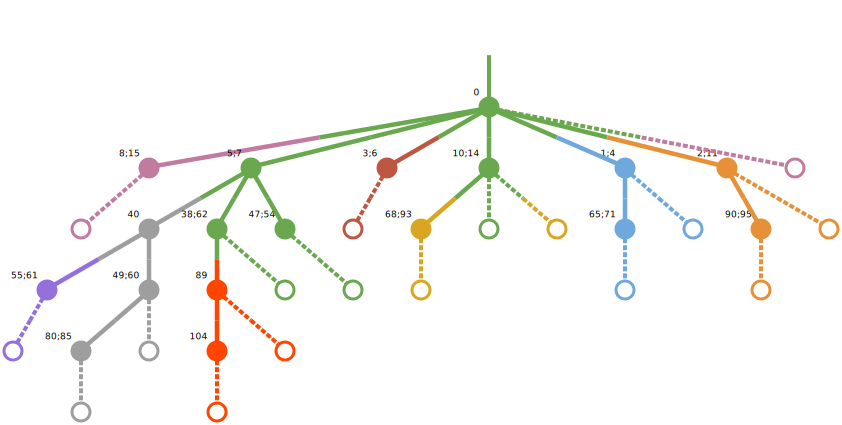

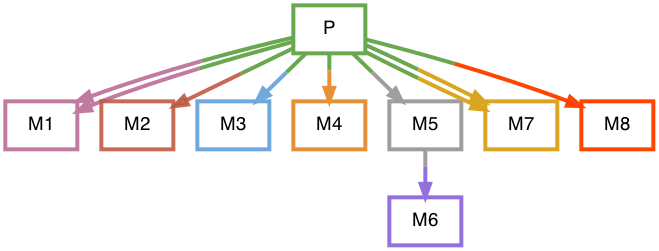

20:47:00 DEBUG

U > 0.05

20:47:00 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.214  0.000 0.000  0.000 0.000   
M1 0.105 0.268 0.623 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.961 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.826  0.112 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.610   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.942 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.277  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.582  0.183  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 140, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.098 0.717 0.036 0.022 0.025   
5;7;9;13;21;25;29;31                         0.872 0.014 0.013 0.015 0.013   
3;6;28;32                                    0.178 0.060 0.635 0.020 0.020   
40                                           0.029 0.031 0.017 0.017 0.019   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.577 0.011 0.013 0.013 0.015   
55;61;63                                     0.031 0.047 0.024 0.028 0.025   
1;4;12;35;37;51;59;64;66                     0.027 0.031 0.018 0.834 0.014   
65;71                                        0.013 0.014 0.015 0.899 0.009   
2;11;36;41;73;74                             0.067 0.028 0.025 0.017 0.781   
49;60;77                                     0.012 0.022 0.014 0.016 0.018   
38;62;67

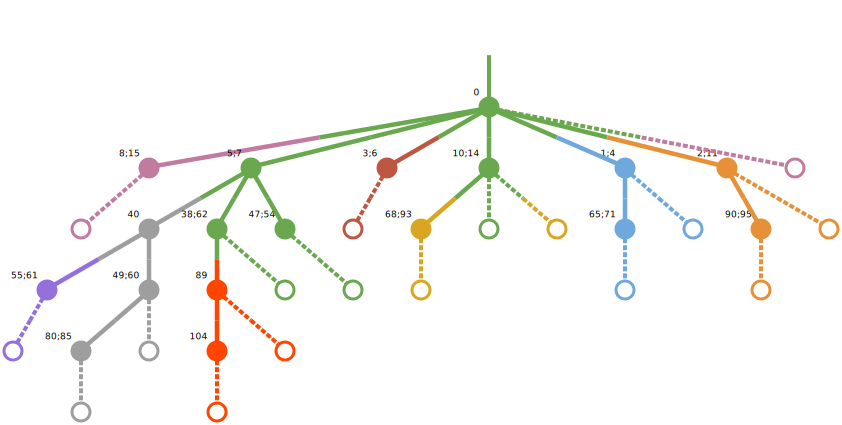

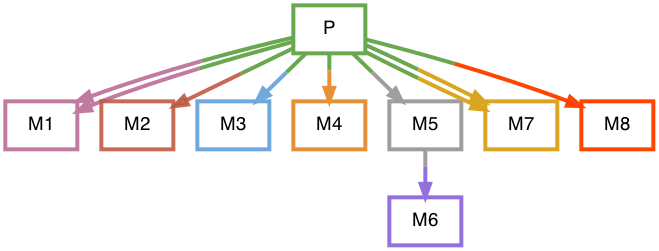

20:47:00 DEBUG

U > 0.05

20:47:00 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.215  0.000 0.000  0.000 0.000   
M1 0.101 0.271 0.623 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.964 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.817  0.113 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.610   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.943 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.281  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.585  0.184  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 160, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.017 0.965 0.004 0.001 0.004   
5;7;9;13;21;25;29;31                         0.987 0.001 0.001 0.001 0.001   
3;6;28;32                                    0.051 0.008 0.928 0.002 0.003   
40                                           0.003 0.003 0.001 0.001 0.002   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.933 0.001 0.001 0.001 0.003   
55;61;63                                     0.003 0.006 0.002 0.002 0.004   
1;4;12;35;37;51;59;64;66                     0.004 0.002 0.003 0.983 0.001   
65;71                                        0.002 0.002 0.002 0.987 0.001   
2;11;36;41;73;74                             0.007 0.002 0.003 0.001 0.976   
49;60;77                                     0.001 0.002 0.001 0.001 0.001   
38;62;67

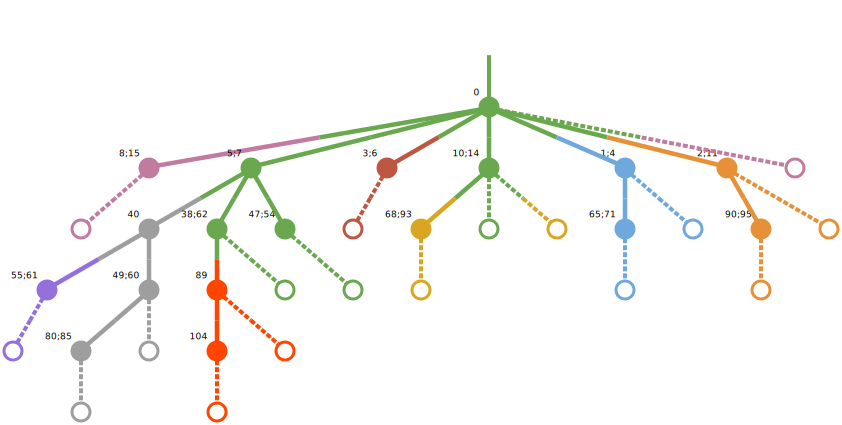

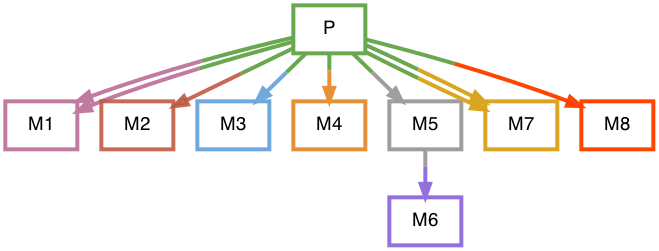

20:47:01 DEBUG

U > 0.05

20:47:01 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.215  0.000 0.000  0.000 0.000   
M1 0.099 0.273 0.624 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.966 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.814  0.115 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.610   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.943 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.283  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.587  0.184  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

============================== INTERMEDIATE TREE ==============================

Iteration: 180, Intermediate best tree idx 2
soft_X
                                                  P    M1    M2    M3    M4  \
8;15;22                                      0.000 1.000 0.000 0.000 0.000   
5;7;9;13;21;25;29;31                         1.000 0.000 0.000 0.000 0.000   
3;6;28;32                                    0.001 0.000 0.999 0.000 0.000   
40                                           0.000 0.000 0.000 0.000 0.000   
10;14;16;24;26;27;30;33;34;39;42;48;52;56;58 0.998 0.000 0.000 0.000 0.000   
55;61;63                                     0.000 0.000 0.000 0.000 0.000   
1;4;12;35;37;51;59;64;66                     0.000 0.000 0.000 1.000 0.000   
65;71                                        0.000 0.000 0.000 1.000 0.000   
2;11;36;41;73;74                             0.000 0.000 0.000 0.000 1.000   
49;60;77                                     0.000 0.000 0.000 0.000 0.000   
38;62;67

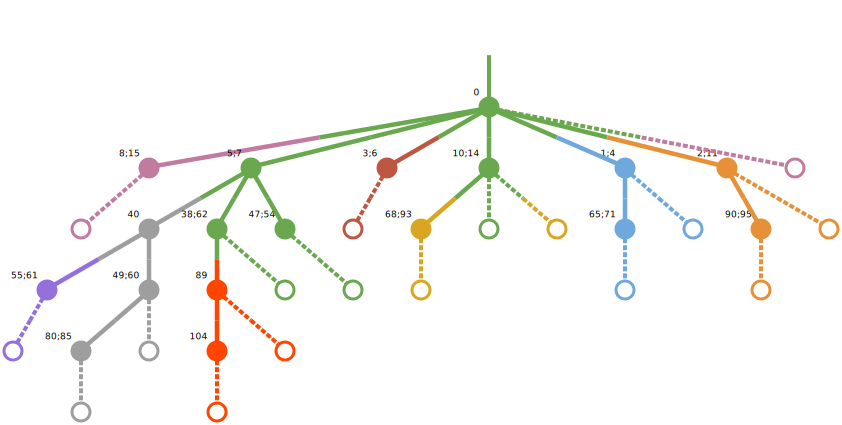

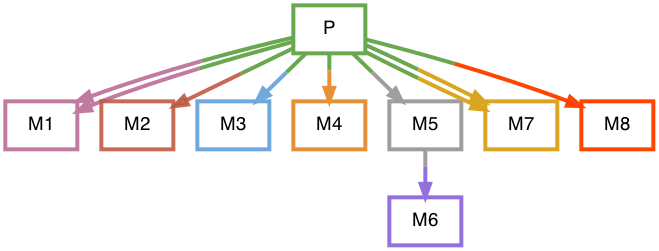

20:47:01 DEBUG

U > 0.05

20:47:01 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.215  0.000 0.000  0.000 0.000   
M1 0.099 0.273 0.624 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.966 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.814  0.115 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.610   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.943 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.283  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.587  0.184  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

****************************** BEST TREE ******************************

Migration number: 10.0
Comigration number: 8.0
Seeding site number: 2.0
Neg log likelihood: 0.756
Reg: 8.733290672302246
Loss: 57.489


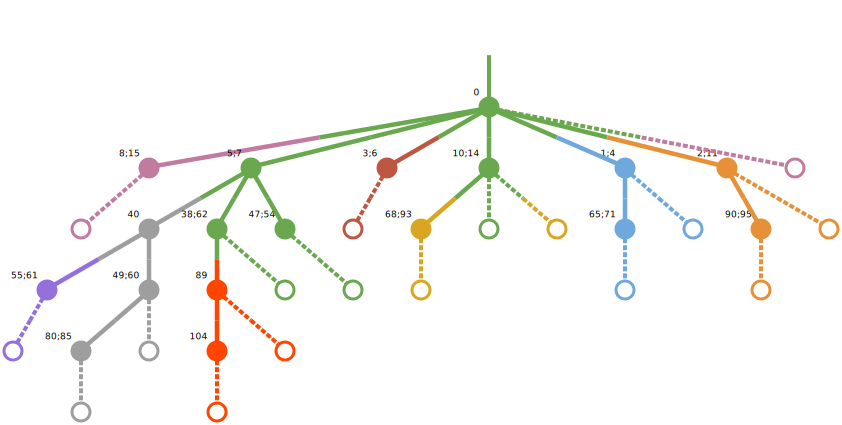

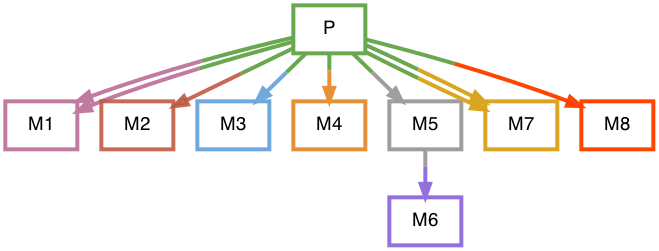

20:47:02 DEBUG
run [PosixPath('dot'), '-Kdot', '-Tsvg']


0 #6aa84fff;1.0:
8;15 #c27ba0ff;1.0:
0 8;15 0.06250000931322575 2.0
0 #6aa84fff;1.0:
5;7 #6aa84fff;0.6487715840339661:#9370dbff;0.1757136732339859:#9e9e9eff;0.17551471292972565:
0 5;7 0.06250000931322575 2.5
0 #6aa84fff;1.0:
3;6 #be5742ff;1.0:
0 3;6 0.06250000931322575 2.5
0 #6aa84fff;1.0:
10;14 #6aa84fff;0.6658554673194885:#daa520ff;0.33414456248283386:
0 10;14 0.06250000931322575 2.5
0 #6aa84fff;1.0:
1;4 #6fa8dcff;1.0:
0 1;4 0.06250000931322575 2.5
0 #6aa84fff;1.0:
2;11 #e69138ff;1.0:
0 2;11 0.06250000931322575 2.5
0 #6aa84fff;1.0:
0_M1 #c27ba0ff;1.0:
0 0_M1 0.06250000931322575 2.5
8;15 #c27ba0ff;1.0:
8_M1 #c27ba0ff;1.0:
8;15 8_M1 0.06250000931322575 2.5
5;7 #6aa84fff;0.6487715840339661:#9370dbff;0.1757136732339859:#9e9e9eff;0.17551471292972565:
40 #9e9e9eff;0.5305490493774414:#9370dbff;0.46945086121559143:
5;7 40 0.06250000931322575 2.5
5;7 #6aa84fff;0.6487715840339661:#9370dbff;0.1757136732339859:#9e9e9eff;0.17551471292972565:
38;62 #6aa84fff;0.7648984789848328:#ff4500ff;0.23510153

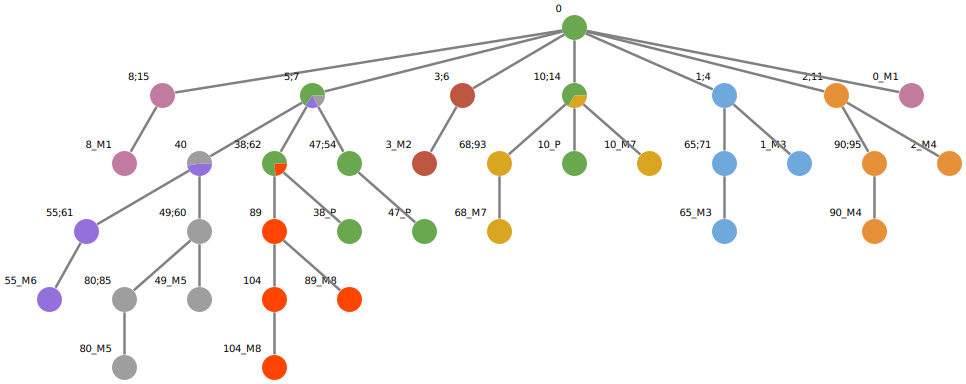

****************************************************************************************************
CPU times: user 21.8 s, sys: 20.9 s, total: 42.7 s
Wall time: 26.2 s


In [13]:
%%time

# No genetic distance

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"),
                                  use_gen_dist=False)




num trees: 2
TREE 1
G
 tensor([[ 0.,  3.,  8.,  4.,  0., 15.,  0.,  9.,  2.,  6.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  5.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0

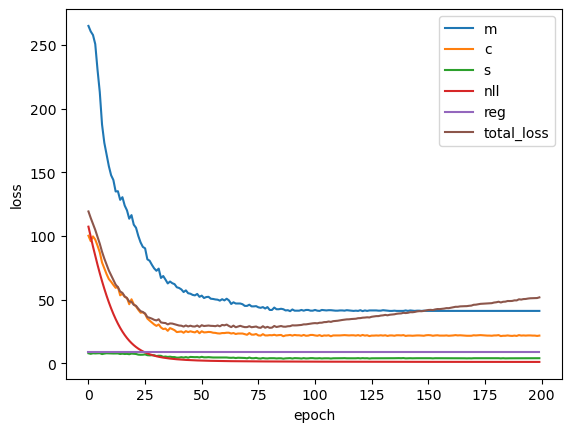

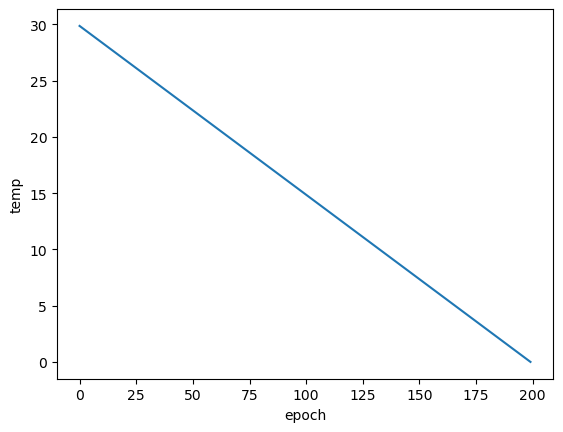

20:26:17 DEBUG

U > 0.05

20:26:17 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.214  0.000 0.000  0.000 0.000   
M1 0.115 0.256 0.621 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.960 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.889  0.094 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.598   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.932 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.262  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.572  0.182  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

Time elapsed: 6.399869
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 14.0
Comigration number: 10.0
Seeding site number: 3.0
Neg log likelihood: 1.196
Reg: 9.0
Genetic distance: -31.0
Loss: 59.696


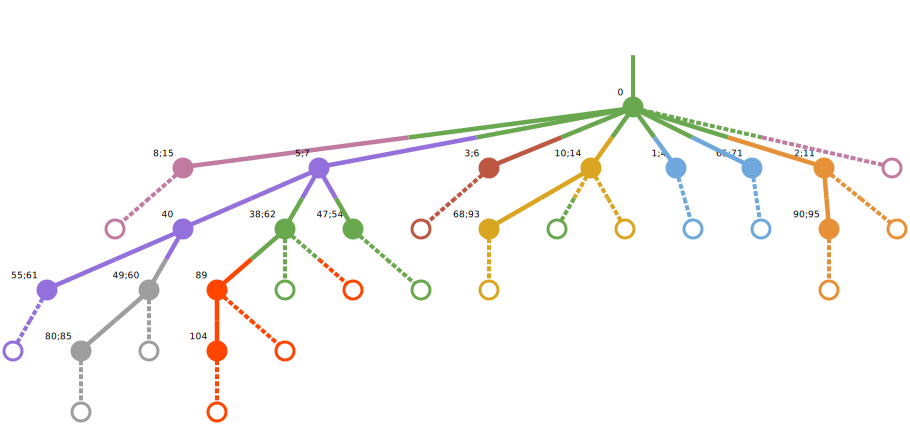

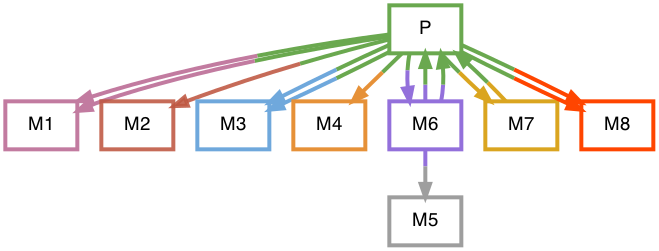

20:26:18 DEBUG
run [PosixPath('dot'), '-Kdot', '-Tsvg']


0 #6aa84fff;1.0:
8;15 #c27ba0ff;1.0:
0 8;15 0.0624999925494194 1.9354305408493406
0 #6aa84fff;1.0:
5;7 #9370dbff;0.30095475912094116:#daa520ff;0.33954918384552:#6fa8dcff;0.2052035629749298:#9e9e9eff;0.15429247915744781:
0 5;7 0.0624999925494194 2.419288176061676
0 #6aa84fff;1.0:
3;6 #be5742ff;1.0:
0 3;6 0.0624999925494194 2.419288176061676
0 #6aa84fff;1.0:
10;14 #daa520ff;1.0:
0 10;14 0.0624999925494194 2.419288176061676
0 #6aa84fff;1.0:
1;4 #6fa8dcff;1.0:
0 1;4 0.0624999925494194 2.419288176061676
0 #6aa84fff;1.0:
65;71 #6fa8dcff;1.0:
0 65;71 0.0624999925494194 2.419288176061676
0 #6aa84fff;1.0:
2;11 #e69138ff;1.0:
0 2;11 0.0624999925494194 2.419288176061676
0 #6aa84fff;1.0:
0_M1 #c27ba0ff;1.0:
0 0_M1 0.0624999925494194 2.419288176061676
8;15 #c27ba0ff;1.0:
8_M1 #c27ba0ff;1.0:
8;15 8_M1 0.0624999925494194 2.419288176061676
5;7 #9370dbff;0.30095475912094116:#daa520ff;0.33954918384552:#6fa8dcff;0.2052035629749298:#9e9e9eff;0.15429247915744781:
40 #9370dbff;0.6304708123207092:#9e9e9eff;0

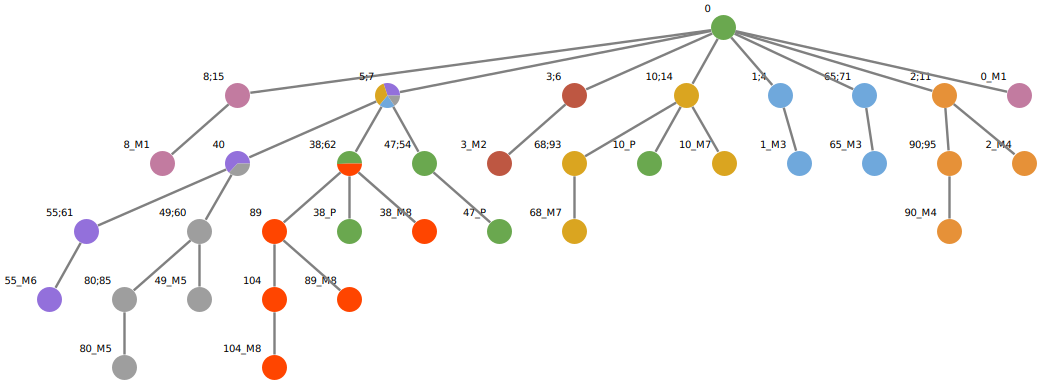

****************************************************************************************************
TREE 2
G
 tensor([[ 0.,  3.,  8.,  4.,  0., 15.,  0.,  9.,  0.,  6.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  5.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.

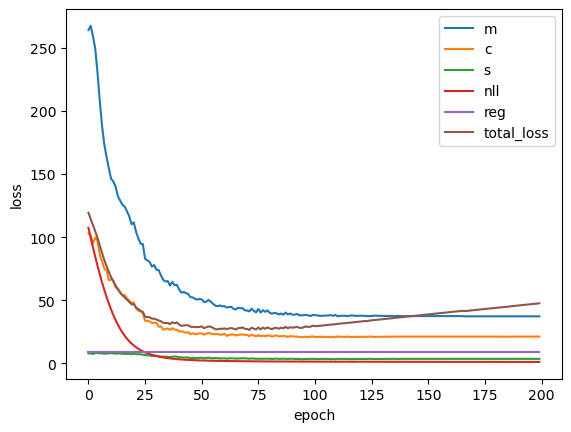

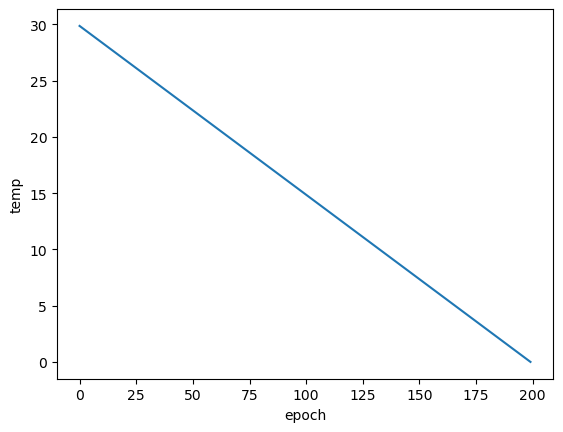

20:26:25 DEBUG

U > 0.05

20:26:25 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.213  0.000 0.000  0.000 0.000   
M1 0.115 0.259 0.621 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.955 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.812  0.116 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.607   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.934 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.269  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.570  0.183  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

Time elapsed: 6.481581
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 12.0
Comigration number: 10.0
Seeding site number: 3.0
Neg log likelihood: 1.195
Reg: 9.0
Genetic distance: -39.0
Loss: 49.695


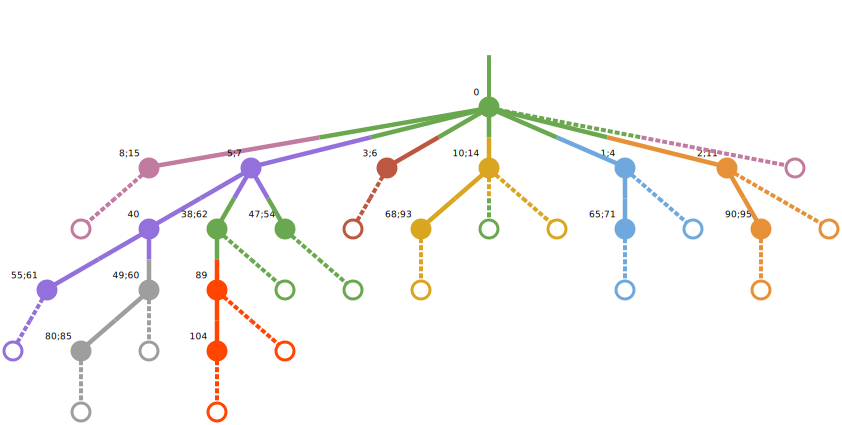

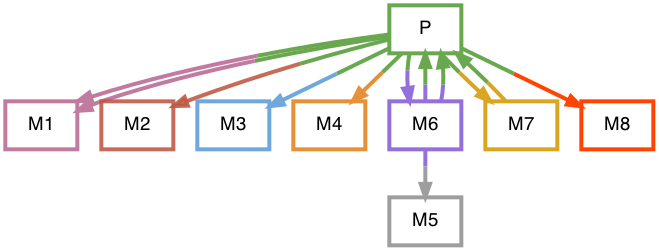

20:26:25 DEBUG
run [PosixPath('dot'), '-Kdot', '-Tsvg']


0 #6aa84fff;1.0:
8;15 #c27ba0ff;1.0:
0 8;15 0.06250000116415322 2.0
0 #6aa84fff;1.0:
5;7 #9370dbff;0.7482618093490601:#9e9e9eff;0.2517382502555847:
0 5;7 0.06250000116415322 2.5
0 #6aa84fff;1.0:
3;6 #be5742ff;1.0:
0 3;6 0.06250000116415322 2.5
0 #6aa84fff;1.0:
10;14 #daa520ff;1.0:
0 10;14 0.06250000116415322 2.5
0 #6aa84fff;1.0:
1;4 #6fa8dcff;1.0:
0 1;4 0.06250000116415322 2.5
0 #6aa84fff;1.0:
2;11 #e69138ff;1.0:
0 2;11 0.06250000116415322 2.5
0 #6aa84fff;1.0:
0_M1 #c27ba0ff;1.0:
0 0_M1 0.06250000116415322 2.5
8;15 #c27ba0ff;1.0:
8_M1 #c27ba0ff;1.0:
8;15 8_M1 0.06250000116415322 2.5
5;7 #9370dbff;0.7482618093490601:#9e9e9eff;0.2517382502555847:
40 #9370dbff;1.0:
5;7 40 0.06250000116415322 2.5
5;7 #9370dbff;0.7482618093490601:#9e9e9eff;0.2517382502555847:
38;62 #6aa84fff;0.6010795831680298:#ff4500ff;0.3989203870296478:
5;7 38;62 0.06250000116415322 2.5
5;7 #9370dbff;0.7482618093490601:#9e9e9eff;0.2517382502555847:
47;54 #6aa84fff;1.0:
5;7 47;54 0.06250000116415322 2.5
3;6 #be5742ff;1.0:

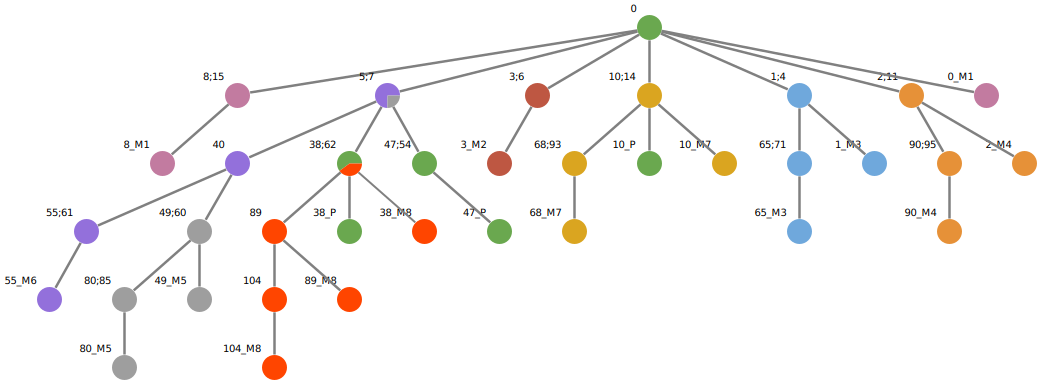

****************************************************************************************************
CPU times: user 23.6 s, sys: 27.5 s, total: 51 s
Wall time: 15.2 s


In [5]:
%%time

# Use genetic distance

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"),
                                  use_gen_dist=True)




[tensor(-47.2123), tensor(-47.4429), tensor(-47.6685), tensor(-47.8894), tensor(-48.1057), tensor(-48.3177), tensor(-48.5255), tensor(-48.7292), tensor(-48.9291), tensor(-49.1252)]


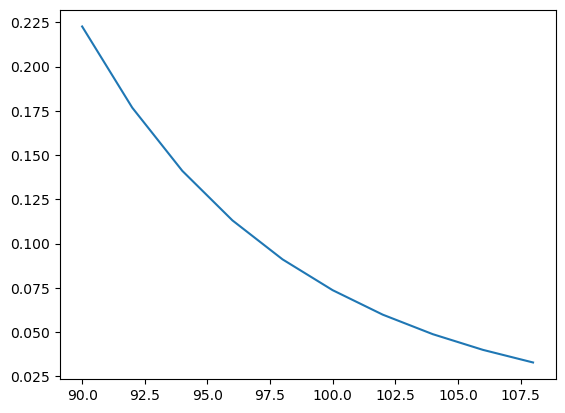

In [6]:
import matplotlib.pyplot as plt
def f(x):
    return -1.0*(torch.log2(torch.tensor(x))/ torch.log2(torch.tensor(1.1)))
X = [x for x in range(90,110,2)]
Y = [f(x) for x in X]
print(Y)
plt.plot(X, torch.softmax(torch.tensor(Y), dim=0))

num trees: 2
TREE 1
G
 tensor([[ 0.,  3.,  8.,  4.,  0., 15.,  0.,  9.,  2.,  6.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  5.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0

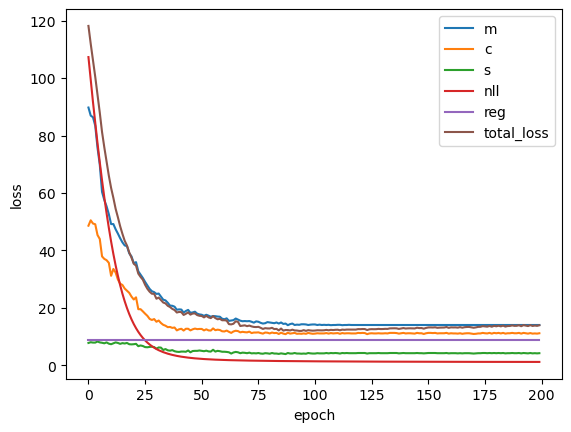

18:49:57 DEBUG

U > 0.05

18:49:57 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.214  0.000 0.000  0.000 0.000   
M1 0.112 0.257 0.623 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.959 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.889  0.094 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.602   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.936 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.262  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.572  0.182  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

Time elapsed: 6.434012
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 14.0
Comigration number: 10.0
Seeding site number: 3.0
Neg log likelihood: 1.217
Reg: 9.0
Genetic distance: -31.0
Loss: 21.717


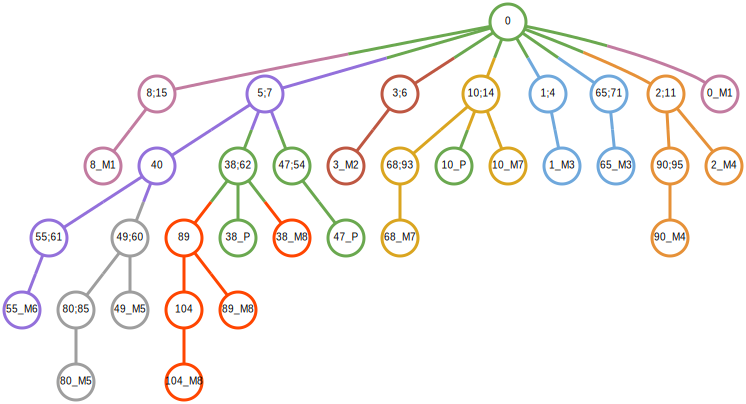

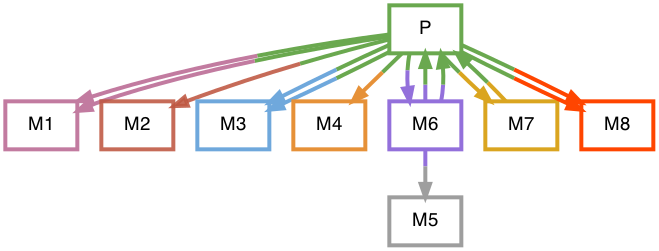

18:49:58 DEBUG
run [PosixPath('dot'), '-Kdot', '-Tsvg']


  0    8;15 0.062499998486600816 2.0
  0    5;7  0.062499998486600816 2.0
  0    3;6  0.062499998486600816 2.0
  0   10;14 0.062499998486600816 2.0
  0    1;4  0.062499998486600816 2.0
  0   65;71 0.062499998486600816 2.0
  0    2;11 0.062499998486600816 2.0
  0    0_M1 0.062499998486600816 2.0
 8;15  8_M1 0.062499998486600816 2.0
 5;7    40  0.062499998486600816 2.0
 5;7  38;62 0.062499998486600816 2.0
 5;7  47;54 0.062499998486600816 2.0
 3;6   3_M2 0.062499998486600816 2.0
  40  55;61 0.062499998486600816 2.0
  40  49;60 0.062499998486600816 2.0
10;14 68;93 0.062499998486600816 2.0
10;14  10_P 0.062499998486600816 2.0
10;14 10_M7 0.062499998486600816 2.0
55;61 55_M6 0.062499998486600816 2.0
 1;4   1_M3 0.062499998486600816 2.0
65;71 65_M3 0.062499998486600816 2.0
 2;11 90;95 0.062499998486600816 2.0
 2;11  2_M4 0.062499998486600816 2.0
49;60 80;85 0.062499998486600816 2.0
49;60 49_M5 0.062499998486600816 2.0
38;62   89  0.062499998486600816 2.0
38;62  38_P 0.062499998486600816 2.0
3

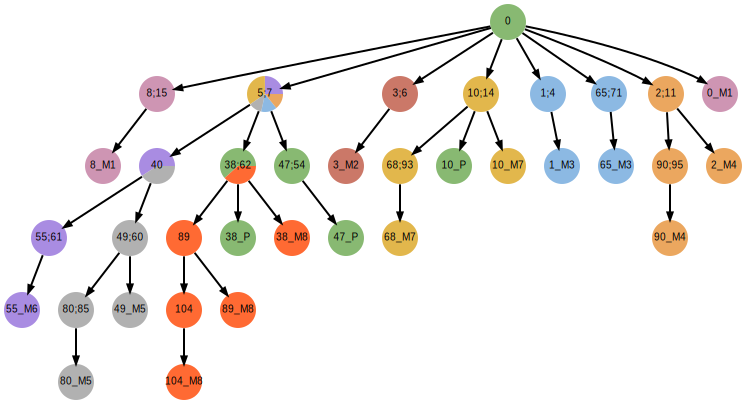

****************************************************************************************************
TREE 2
G
 tensor([[ 0.,  3.,  8.,  4.,  0., 15.,  0.,  9.,  0.,  6.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  5.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.

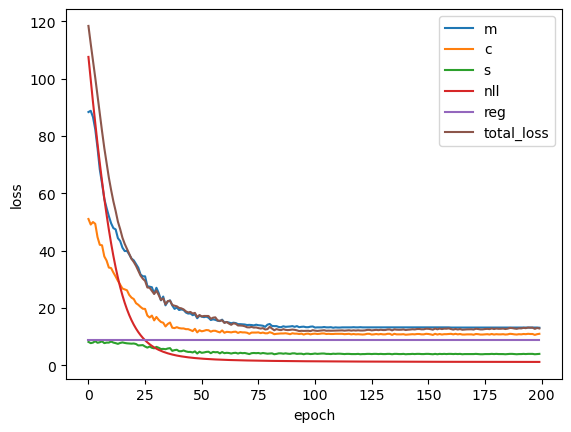

18:50:05 DEBUG

U > 0.05

18:50:05 DEBUG
    norm     0  8;15   5;7   3;6    40  10;14  55;61   1;4  65;71  2;11  \
P  0.000 0.000 0.000 0.000 0.000 0.000  0.213  0.000 0.000  0.000 0.000   
M1 0.107 0.263 0.624 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M2 0.000 0.000 0.000 0.000 0.953 0.000  0.000  0.000 0.000  0.000 0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.814  0.115 0.000   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.610   
M5 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   
M6 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.933 0.000  0.000 0.000   
M7 0.000 0.000 0.000 0.000 0.000 0.000  0.267  0.000 0.000  0.000 0.000   
M8 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000 0.000  0.000 0.000   

    49;60  38;62  47;54  80;85    89  90;95  68;93   104  
P   0.000  0.571  0.182  0.000 0.000  0.000  0.000 0.000  
M1  0.000  0.000  0.000  0.000 0.000  0.000  0.000 0.000  
M2  0.000  0.000  0.000  0.000 

Time elapsed: 6.764524
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 13.0
Comigration number: 11.0
Seeding site number: 4.0
Neg log likelihood: 1.178
Reg: 9.0
Genetic distance: -40.0
Loss: 18.178


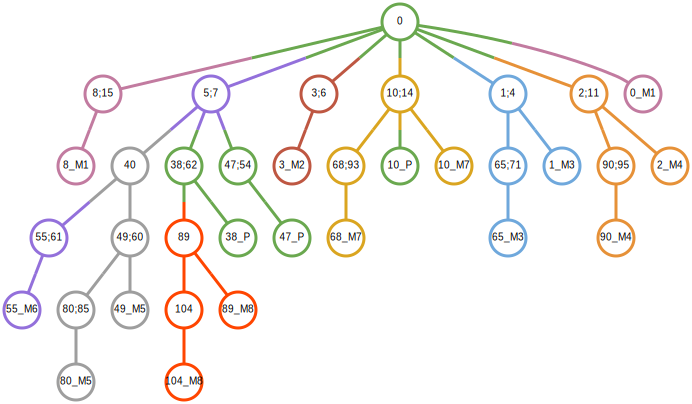

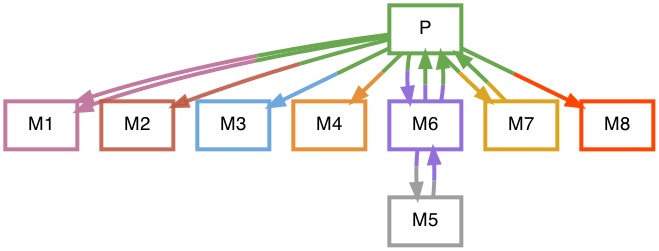

18:50:05 DEBUG
run [PosixPath('dot'), '-Kdot', '-Tsvg']


  0    8;15 0.06250000564614311 2.0
  0    5;7  0.06250000564614311 2.0
  0    3;6  0.06250000564614311 2.0
  0   10;14 0.06250000564614311 2.0
  0    1;4  0.06250000564614311 2.0
  0    2;11 0.06250000564614311 2.0
  0    0_M1 0.06250000564614311 2.0
 8;15  8_M1 0.06250000564614311 2.0
 5;7    40  0.06250000564614311 2.0
 5;7  38;62 0.06250000564614311 2.0
 5;7  47;54 0.06250000564614311 2.0
 3;6   3_M2 0.06250000564614311 2.0
  40  55;61 0.06250000564614311 2.0
  40  49;60 0.06250000564614311 2.0
10;14 68;93 0.06250000564614311 2.0
10;14  10_P 0.06250000564614311 2.0
10;14 10_M7 0.06250000564614311 2.0
55;61 55_M6 0.06250000564614311 2.0
 1;4  65;71 0.06250000564614311 2.0
 1;4   1_M3 0.06250000564614311 2.0
65;71 65_M3 0.06250000564614311 2.0
 2;11 90;95 0.06250000564614311 2.0
 2;11  2_M4 0.06250000564614311 2.0
49;60 80;85 0.06250000564614311 2.0
49;60 49_M5 0.06250000564614311 2.0
38;62   89  0.06250000564614311 2.0
38;62  38_P 0.06250000564614311 2.0
47;54  47_P 0.06250000564614

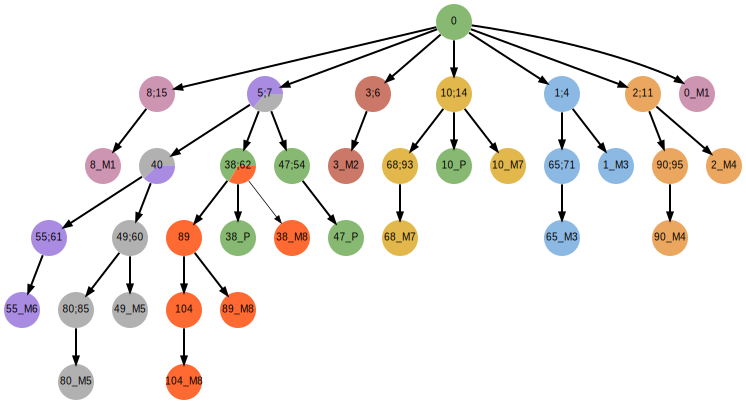

****************************************************************************************************
CPU times: user 22 s, sys: 22.5 s, total: 44.5 s
Wall time: 15.3 s


In [7]:
%%time

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"),
                                  use_gen_dist=True)




In [8]:
!which python


/Users/divyakoyyalagunta/mambaforge/envs/metf/bin/python


In [9]:
p = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/src/test/machina_simulated_data/predictions_wm3_wc2_wg0.5_bs32_11032022"
p = os.path.join(p, num_sites, mig_type)
visualize_ground_truth(os.path.join(p, f"T_tree0_seed{SEED}.predicted.tree"), os.path.join(p, f"G_tree0_seed{SEED}.predicted.tree"))


TypeError: can only concatenate str (not "ParseException") to str

In [ ]:
import fnmatch
import matplotlib.pyplot as plt
def count_trees(sims_data_dir):
    sites = ["m8", "m5"]
    mig_types = ["M", "mS", "R", "S"]
    tree_cts = []
    ct = 0
    seed_ct = 0
    for site in sites:
        for mig_type in mig_types:
            local_ct = 0
            site_mig_data_dir = os.path.join(sims_data_dir, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_data_dir), 'reads_seed*.tsv')
            seeds = [s.replace(".tsv", "").replace("reads_seed", "") for s in seeds]
            for seed in seeds:
                all_mut_trees_fn = os.path.join(sims_data_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt")
                with open(all_mut_trees_fn, 'r') as f:
                    for line in f:
                        if "#trees" in line:
                            tree_ct = int(line.split()[0])
                            tree_cts.append(tree_ct)
                            if tree_ct > 50:
                                print("tree > 50 trees", site, mig_type, seed, tree_ct)
                            ct += tree_ct
                            local_ct += tree_ct
                            break
                seed_ct += 1
            print(site, mig_type, local_ct)
    print(tree_cts)
    plt.hist(tree_cts)
    plt.show()
    plt.close()
    print("Number of total trees:", ct)

count_trees(MACHINA_DATA_DIR)
count_trees(RERUN_SIM_DIR)

In [ ]:
fn = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test.txt"
fn2 = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test2.txt"
from datetime import datetime

output = []
with open(fn) as f:
    for i,line in enumerate(f):
        items = line.strip().split(',')
        if i != 0:
            epoch_time = datetime(1900, 1, 1)
            
            secs = (datetime.strptime(items[4][items[4].find('days')+5:], "%H:%M:%S.%f") - epoch_time).total_seconds()
            #print(secs)
            items[4] = secs
            #print(items)
            output.append(items)
        else:
            output.append(items)

print(output)
import csv
with open(fn2, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter=',', lineterminator='\n')
    for line in output:
        writer.writerow(line)

In [ ]:
mig_type = "S"
SEED = 23

RERUN_SIM_DIR = os.path.join(repo_dir, 'src/data/rerun_machina_sims')
RERUN_SIM_DATA_DIR = os.path.join(RERUN_SIM_DIR, num_sites, mig_type)

print("Manually generated sims")
visualize_ground_truth(os.path.join(RERUN_SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(RERUN_SIM_DATA_DIR, f"G_seed{SEED}.dot"))


In [ ]:
import numpy as np
epoch = 10
x = max(0.01, 1.0/(1.0+np.exp(-1.0*(epoch-10))))
x
#np.max(0.01, 1.0/(1.0+np.exp(-1.0*(epoch-10))))